# Model Selection

## train_test_split

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
X, y = datasets.load_iris(return_X_y = True)
X.shape, y.shape

((150, 4), (150,))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

(90, 4) (90,)
(60, 4) (60,)


0.9666666666666667

## cross_val_score

In [4]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [6]:
print("%0.2f accuracy with a standard deviation of %0.2f"%(scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


In [7]:
from sklearn import metrics
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

In [8]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.97777778, 1.        , 0.95555556, 1.        ])

In [10]:
def custum_cv_2folds(X):
    n = X.shape[0]
    i = 1
    while i <= 2:
        idx = np.arange(n * (i - 1) / 2, n* i / 2, dtype=int)
        yield idx, idx
        i += 1

custum_cv = custum_cv_2folds(X)
cross_val_score(clf, X, y, cv = custum_cv)

array([1.        , 0.97333333])

In [14]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

0.9333333333333333

In [16]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.93333333, 0.95555556, 0.93333333, 0.97777778])

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ["precision_macro", 'recall_macro']
clf = svm.SVC(kernel="linear", C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
print(sorted(scores.keys()))
scores['test_recall_macro']

['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']


array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [19]:
from sklearn.metrics import make_scorer
scoring = {'prec_macro':'precision_macro', 'rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=True)
print(sorted(scores.keys()))
scores['train_rec_macro']

['fit_time', 'score_time', 'test_prec_macro', 'test_rec_macro', 'train_prec_macro', 'train_rec_macro']


array([0.975     , 0.975     , 0.99166667, 0.98333333, 0.98333333])

In [20]:
scores = cross_validate(clf, X, y, scoring='precision_macro', cv=5, return_estimator=True)
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

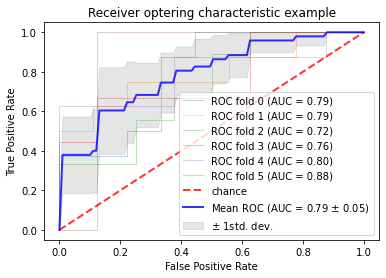

In [28]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200*n_features)]
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test], name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)'%(mean_auc, std_auc), lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1std. dev.')
ax.set(xlim = [-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver optering characteristic example")
ax.legend(loc="lower right")
plt.show()

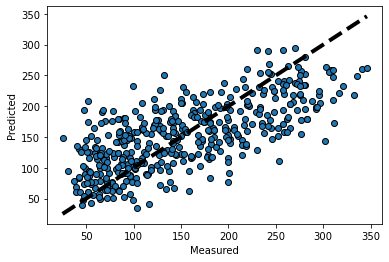

In [38]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
lr = linear_model.LinearRegression()
X, y = datasets.load_diabetes(return_X_y=True)
predicted = cross_val_predict(lr, X, y, cv=10)
fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## KFold and RepeatedKFold and LeaveOneOut

In [39]:
import numpy as np
from sklearn.model_selection import KFold
X = ['a', 'b', 'c', 'd']
kf = KFold(n_splits=2)
for train, test in kf.split(X):
    print("%s %s"%(train, test))

[2 3] [0 1]
[0 1] [2 3]


In [40]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
random_state=12883823
rkf = RepeatedKFold(n_splits=2, n_repeats = 2, random_state=random_state)
for train, test in rkf.split(X):
    print("%s %s"%(train, test))

[2 3] [0 1]
[0 1] [2 3]
[0 2] [1 3]
[1 3] [0 2]


In [41]:
from sklearn.model_selection import LeaveOneOut
X = [1, 2, 3, 4]
loo = LeaveOneOut()
for train, test in loo.split(X):
    print("%s %s"%(train, test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


In [42]:
from sklearn.model_selection import LeavePOut
X = np.ones(4)
lpo = LeavePOut(p=2)
for train, test in lpo.split(X):
    print("%s %s"%(train, test))

[2 3] [0 1]
[1 3] [0 2]
[1 2] [0 3]
[0 3] [1 2]
[0 2] [1 3]
[0 1] [2 3]


## ShuffleSplit and StratifiedKFold and Stratified Shuffle Split

In [44]:
from sklearn.model_selection import ShuffleSplit
X = np.arange(10)
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
for train_index, test_index in ss.split(X):
    print("%s %s"%(train_index, test_index))

[9 1 6 7 3 0 5] [2 8 4]
[2 9 8 0 6 7 4] [3 5 1]
[4 5 1 0 6 9 7] [2 3 8]
[2 7 5 8 0 3 4] [6 1 9]
[4 1 0 6 8 9 3] [5 2 7]


In [47]:
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print('Train - {}  |  test - {}'.format(np.bincount(y[train]), np.bincount(y[test])))
kf = KFold(n_splits = 3)
for train, test in kf.split(X, y):
    print("trian - {}  |  test - {}".format(np.bincount(y[train]), np.bincount(y[test])))

Train - [30  3]  |  test - [15  2]
Train - [30  3]  |  test - [15  2]
Train - [30  4]  |  test - [15  1]
trian - [28  5]  |  test - [17]
trian - [28  5]  |  test - [17]
trian - [34]  |  test - [11  5]


In [48]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
print(sss.get_n_splits(X, y))
print(sss)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

5
StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.5,
            train_size=None)
TRAIN: [5 2 3] TEST: [4 1 0]
TRAIN: [5 1 4] TEST: [0 2 3]
TRAIN: [5 0 2] TEST: [4 3 1]
TRAIN: [4 1 0] TEST: [2 3 5]
TRAIN: [0 5 1] TEST: [3 4 2]


## Group

In [2]:
from sklearn.model_selection import GroupKFold
X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y = ["a", 'b', 'b','b', 'c', 'c', 'c', 'd', 'd', 'd']
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]
gkf = GroupKFold(n_splits=3)
for train, test in gkf.split(X, y, groups = groups):
    print("%s %s"%(train, test))

[0 1 2 3 4 5] [6 7 8 9]
[0 1 2 6 7 8 9] [3 4 5]
[3 4 5 6 7 8 9] [0 1 2]


In [3]:
from sklearn.model_selection import LeaveOneGroupOut
X = [1, 5, 10, 50, 60, 70, 80]
y = [0, 1, 1, 2, 2, 2, 2]
groups = [1, 1, 2, 2, 3, 3, 3]
logo = LeaveOneGroupOut()
for train, test in logo.split(X, y, groups=groups):
    print("%s %s"%(train, test))

[2 3 4 5 6] [0 1]
[0 1 4 5 6] [2 3]
[0 1 2 3] [4 5 6]


In [7]:
import numpy as np
from sklearn.model_selection import LeavePGroupsOut
X = np.arange(6)
y = [1, 1, 2, 2, 3, 3]
groups = [1, 1, 2, 2, 3, 3]
lpgo = LeavePGroupsOut(n_groups=2)
for train, test in lpgo.split(X, y, groups=groups):
    print("%s %s"%(train, test))

[4 5] [0 1 2 3]
[2 3] [0 1 4 5]
[0 1] [2 3 4 5]


In [8]:
from sklearn.model_selection import GroupShuffleSplit
X = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001]
y = ['a', 'b', 'b', 'b', 'c', 'c', 'c', 'a']
groups = [1, 1, 2, 2, 3, 3, 4, 4]
gss = GroupShuffleSplit(n_splits=4, test_size=0.5, random_state=0)
for train, test in gss.split(X, y, groups=groups):
    print("%s %s"%(train, test))

[0 1 2 3] [4 5 6 7]
[2 3 6 7] [0 1 4 5]
[2 3 4 5] [0 1 6 7]
[4 5 6 7] [0 1 2 3]


In [11]:
import numpy as np
from sklearn.model_selection import PredefinedSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
test_fold = [0, 1, -1, 1]
ps = PredefinedSplit(test_fold)
print(ps.get_n_splits())
print(ps)
for train_index, test_index in ps.split():
    print("Train:", train_index, "test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

2
PredefinedSplit(test_fold=array([ 0,  1, -1,  1]))
Train: [1 2 3] test: [0]
Train: [0 2] test: [1 3]


In [13]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
X = np.array([0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 0.001])
y = np.array(['a', 'b', 'b', 'b', 'c', 'c', 'c', 'a'])
groups = np.array([1, 1, 2, 2, 3, 3, 4, 4])
train_indx, test_indx = next(GroupShuffleSplit(random_state=7).split(X, y, groups))
X_train, X_test, y_train, y_test = X[train_indx], X[test_indx], y[train_indx], y[test_indx]
print(X_train.shape, X_test.shape)
np.unique(groups[train_indx]), np.unique(groups[test_indx])

(6,) (2,)


(array([1, 2, 4]), array([3]))

## Time Series Split

In [14]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)
for train_index, test_index in tscv.split(X):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TimeSeriesSplit(max_train_size=None, n_splits=5)
Train: [0] Test: [1]
Train: [0 1] Test: [2]
Train: [0 1 2] Test: [3]
Train: [0 1 2 3] Test: [4]
Train: [0 1 2 3 4] Test: [5]


In [16]:
X = np.random.randn(12, 2)
y = np.random.randint(0, 2, 12)
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Train: [0 1 2] Test: [3 4 5]
Train: [0 1 2 3 4 5] Test: [6 7 8]
Train: [0 1 2 3 4 5 6 7 8] Test: [ 9 10 11]
TRAIN: [0 1 2] TEST [3 4 5]
TRAIN: [0 1 2 3 4 5] TEST [6 7 8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST [ 9 10 11]


In [19]:
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)
for train, test in tscv.split(X):
    print("%s %s" %(train, test))

TimeSeriesSplit(max_train_size=None, n_splits=3)
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


## Permutation Test Score

In [28]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
import numpy as np
n_uncorrelated_features = 2200
rng = np.random.RandomState(seed=0)
X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
clf = SVC(kernel='linear', random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)
score_iris, pem_scores_iris, pvalue_iris = permutation_test_score(clf, X, y, scoring="accuracy", cv=cv,
                                                                  n_permutations=1000)
score_rand, pem_scores_rand, pvalue_rand = permutation_test_score(clf, X_rand, y, scoring="accuracy", cv=cv,
                                                                  n_permutations=1000)

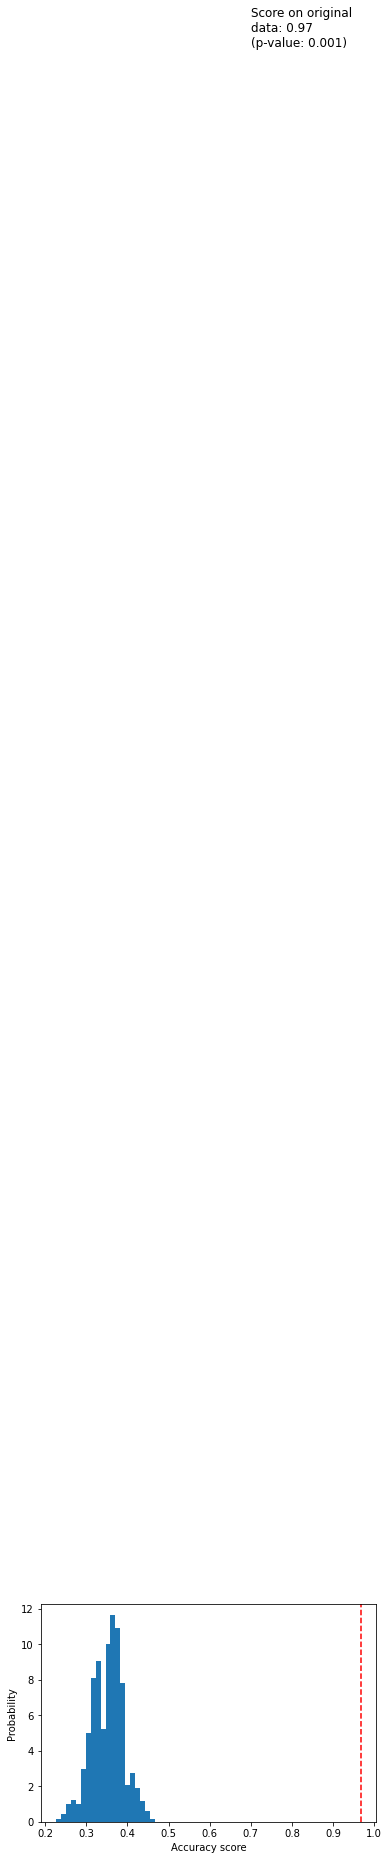

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(pem_scores_iris, bins=20, density=True)
ax.axvline(score_iris, ls="--", color="r")
score_label = (f"Score on original\ndata: {score_iris:.2f}\n"f"(p-value: {pvalue_iris:.3f})")
ax.text(0.7, 100, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

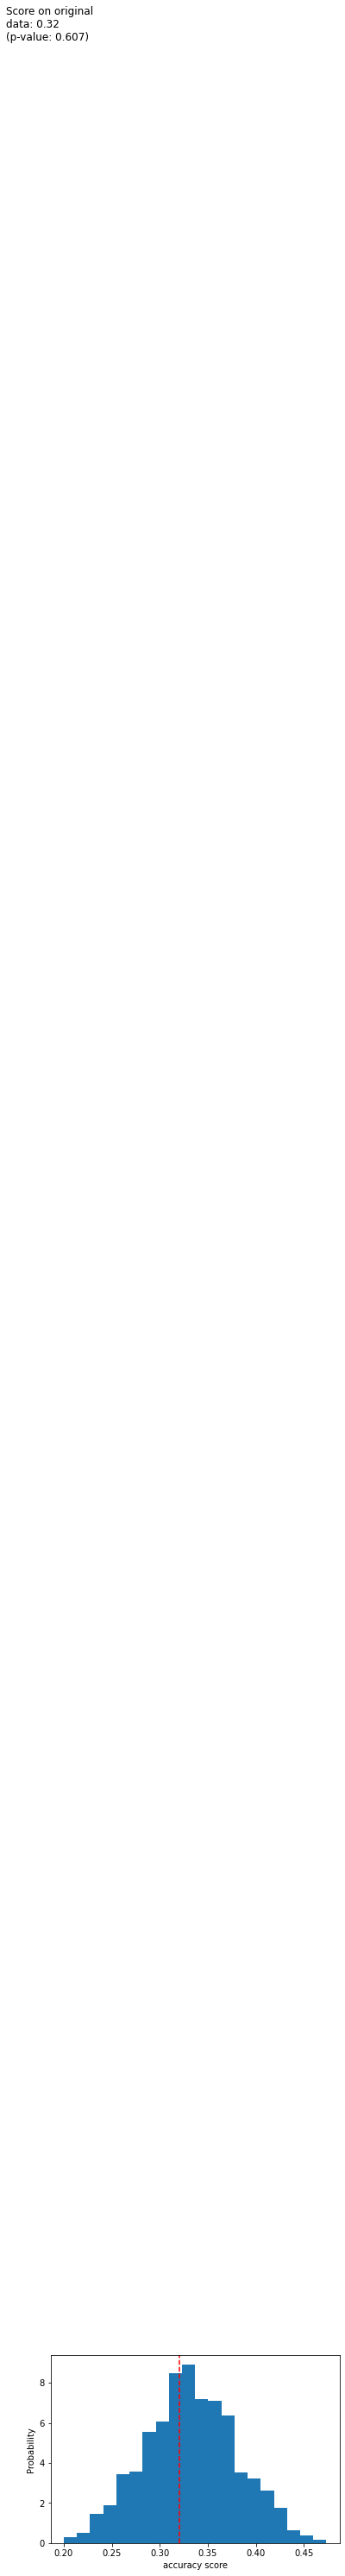

In [32]:
fig, ax = plt.subplots()
ax.hist(pem_scores_rand, bins=20, density=True)
ax.axvline(score_rand, ls="--", color='r')
score_label = (f"Score on original \ndata: {score_rand:.2f}\n"f"(p-value: {pvalue_rand:.3f})")
ax.text(0.14, 125, score_label, fontsize=12)
ax.set_xlabel("accuracy score")
ax.set_ylabel("Probability")
plt.show()

# Tunning the hyper parameters of as estimator

## GridSearchCV

In [36]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', "rbf"), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [37]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [43]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s')
categories = ['alt.atheism', 'talk.religion.misc']
print("Loading 20 newsgroups datasets for categories:")
print(categories)
data = fetch_20newsgroups(subset = 'train', categories=categories)
print("%d documents"%len(data.filenames))
print("%d categories"%len(data.target_names))
print()

pipeline = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])
parameters = {
    'vect__max_df':(0.5, 0.75, 1.0),
    'vect__ngram_range':((1, 1), (1, 2)),
    'clf__max_iter':(20, ),
    "clf__alpha": (0.00001, 0.000001),
    'clf__penalty':('l2', 'elasticnet')
}
if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs"%(time() - t0))
    print()
    print("Best score: %0.3f"%grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r"%(param_name, best_parameters[param_name]))

Loading 20 newsgroups datasets for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   25.0s finished


done in 26.058s

Best score: 0.951
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'l2'
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)


Average difference of 0.007581 with std. dev. of 0.007833.


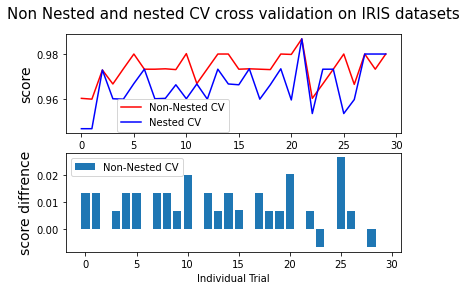

In [46]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np
NUM_TRIALS = 30
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
p_grid = {"C": [1, 10, 100], 
         "gamma": [.01, .1]}
svm = SVC(kernel='rbf')
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)
for i in range(NUM_TRIALS):
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_
    nested_score = cross_val_score(clf, X=X_iris, y = y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()
score_difference = non_nested_scores - nested_scores
print("Average difference of {:6f} with std. dev. of {:6f}.".format(score_difference.mean(), score_difference.std()))
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize='14')
plt.legend([non_nested_scores_line, nested_line], ["Non-Nested CV", "Nested CV"], bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non Nested and nested CV cross validation on IRIS datasets", x=.5, y=1.1, fontsize="15")
plt.subplot(212)
difference_plot= plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial")
plt.legend([difference_plot], ["Non-Nested CV", "Nested CV"], bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score diffrence", fontsize="14")
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [5]:
X, y = make_hastie_10_2(n_samples=8000, random_state=42)
scoring = {'AUC':'roc_auc', "Accuracy":make_scorer(accuracy_score)}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid={"min_samples_split":range(2, 403, 10)}, 
                 scoring=scoring, refit='AUC', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_

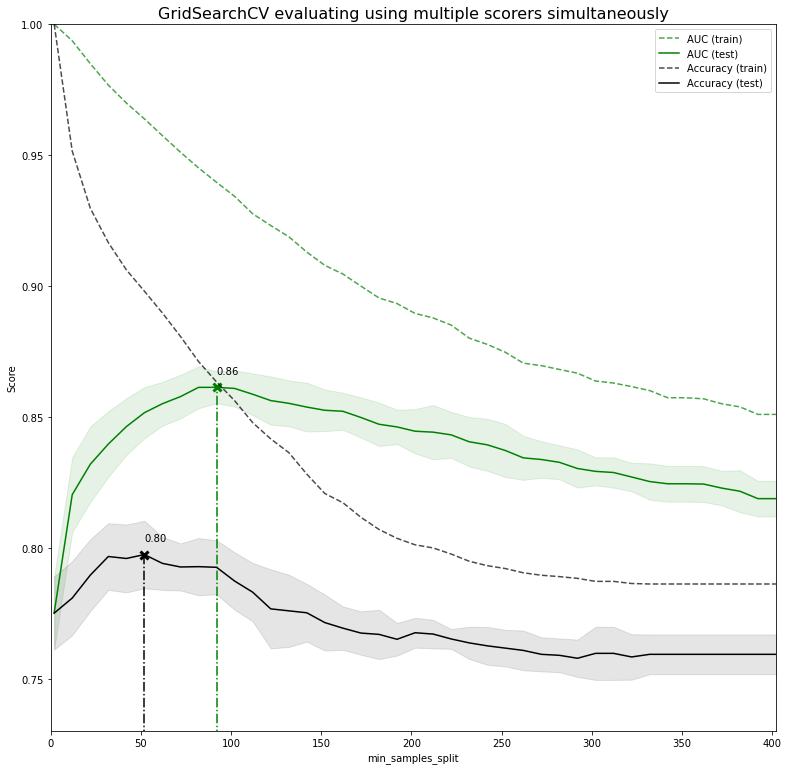

In [9]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)
plt.xlabel("min_samples_split")
plt.ylabel("Score")
ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)
for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s'%(sample, scorer)]
        sample_score_std = results['std_%s_%s'%(sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std, sample_score_mean + sample_score_std, alpha=0.1
                       if sample == "test" else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color, alpha=1 if sample=='test' else 0.7,
                label="%s (%s)"%(scorer, sample))
    best_index = np.nonzero(results['rank_test_%s'%scorer] == 1)[0][0]
    best_score = results['mean_test_%s'%scorer][best_index]
    ax.plot([X_axis[best_index], ] * 2, [0, best_score], linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)
    ax.annotate("%0.2f"%best_score, (X_axis[best_index], best_score + 0.005))
plt.legend(loc="best")
plt.grid(False)
plt.show()

The best_index_is 2
The n_components selected is 10
The corresponding accuracy score is 0.88


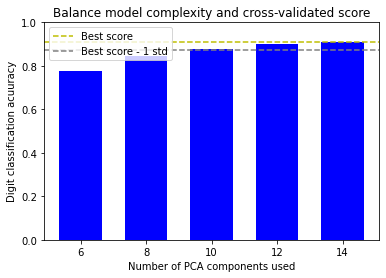

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
def lower_bound(cv_results):
    best_score_idx = np.argmax(cv_results['mean_test_score'])
    return (cv_results['mean_test_score'][best_score_idx] - cv_results['std_test_score'][best_score_idx])

def best_low_complexity(cv_results):
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results["mean_test_score"] >= threshold)
    best_idx = candidate_idx[cv_results['param_reduce_dim__n_components'][candidate_idx].argmin()]
    return best_idx

pipe = Pipeline([('reduce_dim', PCA(random_state=42)), ('classify', LinearSVC(random_state=42, C=0.01))])
param_grid = {'reduce_dim__n_components': [6, 8, 10, 12, 14]}
grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid, scoring="accuracy", refit=best_low_complexity)
X, y = load_digits(return_X_y = True)
grid.fit(X, y)
n_components = grid.cv_results_['param_reduce_dim__n_components']
test_scores = grid.cv_results_['mean_test_score']
plt.figure()
plt.bar(n_components, test_scores, width=1.3, color='b')
lower = lower_bound(grid.cv_results_)
plt.axhline(np.max(test_scores), linestyle="--", color='y', label='Best score')
plt.axhline(lower, linestyle="--", color='.5', label="Best score - 1 std")
plt.title("Balance model complexity and cross-validated score")
plt.xlabel('Number of PCA components used')
plt.ylabel("Digit classification acuuracy")
plt.xticks(n_components.tolist())
plt.ylim((0, 1.0))
plt.legend(loc='upper left')
best_index_ = grid.best_index_
print("The best_index_is %d"%(best_index_))
print("The n_components selected is %d"%n_components[best_index_])
print("The corresponding accuracy score is %.2f"%grid.cv_results_['mean_test_score'][best_index_])
plt.show()

## RandomizedSearchCV

In [20]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
iris = load_iris()
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0)
distribution = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distribution, random_state=0)
search = clf.fit(iris.data, iris.target)
search.best_params_

{'C': 2.195254015709299, 'penalty': 'l1'}

In [23]:
from time import time
import numpy as np
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier
X, y = load_digits(return_X_y = True)
clf = SGDClassifier(loss='hinge', penalty='elasticnet', fit_intercept=True)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rankL {0}".format(i))
            print("Mean validation: {0:.3f} (std: {1:.3f})".format(results['mean_test_score'][candidate],
                                                                   results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
param_dist = {'average':[True, False], 'l1_ratio':stats.uniform(0, 1), 'alpha':loguniform(1e-4, 1e0)}
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)
start = time()
random_search.fit(X, y)
print("randomizedSearchCV took %.2f seconds for %d candidates parameter setting."%((time() - start), n_iter_search))
report(random_search.cv_results_)
param_grid = {'average':[True, False], 'l1_ratio':np.linspace(0, 1, num=10),
              'alpha':np.power(10, np.arange(-4, 1, dtype=float))}
grid_search = GridSearchCV(clf, param_grid = param_grid)
start = time()
grid_search.fit(X, y)
print("GridSearchCV took %.2f Seconds for %d candidate parameter settings."%(time() - start,
                                                                             len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

randomizedSearchCV took 68.75 seconds for 20 candidates parameter setting.
Model with rankL 1
Mean validation: 0.925 (std: 0.033)
Parameters: {'alpha': 0.00010982407760411501, 'average': True, 'l1_ratio': 0.8940298780176643}

Model with rankL 2
Mean validation: 0.923 (std: 0.027)
Parameters: {'alpha': 0.0008773984217689357, 'average': True, 'l1_ratio': 0.1714541850171677}

Model with rankL 3
Mean validation: 0.923 (std: 0.027)
Parameters: {'alpha': 0.0002441705170540201, 'average': True, 'l1_ratio': 0.6694665881402191}



c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


GridSearchCV took 300.93 Seconds for 100 candidate parameter settings.
Model with rankL 1
Mean validation: 0.932 (std: 0.027)
Parameters: {'alpha': 0.0001, 'average': True, 'l1_ratio': 0.0}

Model with rankL 2
Mean validation: 0.930 (std: 0.034)
Parameters: {'alpha': 1.0, 'average': True, 'l1_ratio': 0.0}

Model with rankL 3
Mean validation: 0.927 (std: 0.029)
Parameters: {'alpha': 0.0001, 'average': True, 'l1_ratio': 0.2222222222222222}

Model with rankL 3
Mean validation: 0.927 (std: 0.031)
Parameters: {'alpha': 0.001, 'average': True, 'l1_ratio': 0.3333333333333333}



In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
X, y = make_moons()
calibrated_forest = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=10))
param_grid = {
    'base_estimator__max_depth':[2, 4, 6, 8]
}
search = GridSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=10)),
             param_grid={'base_estimator__max_depth': [2, 4, 6, 8]})

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
pipe = Pipeline([('select', SelectKBest()), ('model', calibrated_forest)])
param_grid = {'select__k':[1, 2], 'model__base_estimator__max_depth':[2, 4, 6, 8]}
search = GridSearchCV(pipe, param_grid, cv=5).fit(X, y)

# Metrics and Scoring: quantifying the quality of predictions 

In [1]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
grid = GridSearchCV(LinearSVC(), param_grid={'C': [1, 10]}, scoring=ftwo_scorer, cv=5)

In [8]:
import numpy as np
def my_custom_loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    return np.log1p(diff)
score = make_scorer(my_custom_loss_func, greater_is_better=False)
X = [[1], [1]]
y = [0, 1]
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf = clf.fit(X, y)
print(my_custom_loss_func(y, clf.predict(X)))
score(clf, X, y)

[0.         0.69314718]


array([-0.        , -0.69314718])

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]
print(accuracy_score(y_true, y_pred))
accuracy_score(y_true, y_pred, normalize=False)

0.5


2

In [15]:
accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))

0.5

In [18]:
from sklearn.metrics import balanced_accuracy_score
y_true = [0, 1, 0, 0, 1, 0]
y_pred = [0, 1, 0, 0, 0, 1]
balanced_accuracy_score(y_true, y_pred)

0.625

In [19]:
from sklearn.metrics import cohen_kappa_score
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
cohen_kappa_score(y_true, y_pred)

0.4285714285714286

## Confusion matrix and classification Report

In [35]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
cm = confusion_matrix(y_true, y_pred)
cm

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]], dtype=int64)

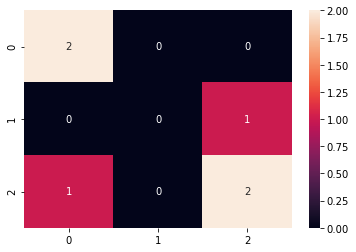

In [36]:
import seaborn as sns
sns.heatmap(cm, annot=True)

In [24]:
y_true = [0, 0, 0, 1, 1, 1, 1, 1]
y_pred = [0, 1, 0, 1, 0, 1, 0, 1]
confusion_matrix(y_true, y_pred, normalize='all')

array([[0.25 , 0.125],
       [0.25 , 0.375]])

In [25]:
y_true = [0, 0, 0, 1, 1, 1, 1, 1]
y_pred = [0, 1, 0, 1, 0, 1, 0, 1]
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

(2, 1, 2, 3)

In [33]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 0]
y_pred = [0, 0, 2, 1, 0]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.67      1.00      0.80         2
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.50      0.67         2

    accuracy                           0.60         5
   macro avg       0.56      0.50      0.49         5
weighted avg       0.67      0.60      0.59         5



In [34]:
from sklearn.metrics import hamming_loss
y_pred = [1, 2, 3, 4]
y_true = [2, 2, 3, 4]
hamming_loss(y_true, y_pred)

0.25

In [37]:
import numpy as np
from sklearn.metrics import precision_recall_curve
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
print(precision)
print(recall)
print(thresholds)

[0.66666667 0.5        1.         1.        ]
[1.  0.5 0.5 0. ]
[0.35 0.4  0.8 ]


In [39]:
from sklearn import metrics
y_pred = [0, 1, 0, 0]
y_true = [0, 1, 0, 1]
print(metrics.precision_score(y_true, y_pred))
print(metrics.recall_score(y_true, y_pred))
print(metrics.f1_score(y_true, y_pred))
print(metrics.fbeta_score(y_true, y_pred, beta=0.5))
print(metrics.fbeta_score(y_true, y_pred, beta=1))
print(metrics.fbeta_score(y_true, y_pred, beta=2))
print(metrics.precision_recall_fscore_support(y_true, y_pred, beta=0.5))

1.0
0.5
0.6666666666666666
0.8333333333333334
0.6666666666666666
0.5555555555555556
(array([0.66666667, 1.        ]), array([1. , 0.5]), array([0.71428571, 0.83333333]), array([2, 2], dtype=int32))


In [41]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
t_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
precision, recall, threshold = precision_recall_curve(y_true, y_scores)
print(precision)
print(recall)
print(threshold)
average_precision_score(y_true, y_scores)

[1. 1. 1.]
[1.  0.5 0. ]
[0.4 0.8]


1.0

In [43]:
from sklearn import metrics
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
print(metrics.precision_score(y_true, y_pred, average='macro'))
print(metrics.recall_score(y_true, y_pred, average='micro'))
print(metrics.f1_score(y_true, y_pred, average='weighted'))
print(metrics.fbeta_score(y_true, y_pred, average='macro', beta=0.5))
print(metrics.precision_recall_fscore_support(y_true, y_pred, beta=0.5, average=None))

0.2222222222222222
0.3333333333333333
0.26666666666666666
0.23809523809523805
(array([0.66666667, 0.        , 0.        ]), array([1., 0., 0.]), array([0.71428571, 0.        , 0.        ]), array([2, 2, 2], dtype=int32))


In [50]:
import numpy as np
from sklearn.metrics import jaccard_score
y_true = np.array([[0, 1, 1], [1, 1, 0]])
y_pred = np.array([[1, 1, 1], [1, 0, 0]])
jaccard_score(y_true[0], y_pred[0])

0.6666666666666666

In [51]:
print(jaccard_score(y_true, y_pred, average='samples'))
print(jaccard_score(y_true, y_pred, average='macro'))
print(jaccard_score(y_true, y_pred, average=None))

0.5833333333333333
0.6666666666666666
[0.5 0.5 1. ]


## Hinge Loss

In [53]:
from sklearn import svm
from sklearn.metrics import hinge_loss
X = [[0], [1]]
y = [-1, 1]
est = svm.LinearSVC(random_state=0)
est.fit(X, y)
pred_decision = est.decision_function([[-2], [3], [0.5]])
print(pred_decision)
hinge_loss([-1, 1, 1], pred_decision)

[-2.18177944  2.36355888  0.09088972]


0.3030367603854425

In [56]:
X = np.array([[0], [1], [2], [3]])
Y = np.array([0, 1, 2, 3])
labels = np.array([0, 1, 2, 3])
est = svm.LinearSVC()
est.fit(X, Y)
pred_decision = est.decision_function([[-1], [2], [3]])
y_true = [0, 2, 3]
hinge_loss(y_true, pred_decision, labels)

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0 1 2 3] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


0.5641167014179077

## Log Loss and Matthews_corrcoef

In [58]:
from sklearn.metrics import log_loss
y_true = [0, 0, 1, 1]
y_pred = [[.9, .1], [.8, .2], [.3, .7], [.01, .99]]
log_loss(y_true, y_pred)

0.1738073366910675

In [59]:
from sklearn.metrics import matthews_corrcoef
y_true = [+1, +1, +1, -1]
y_pred = [+1, -1, +1, +1]
matthews_corrcoef(y_true, y_pred)

-0.3333333333333333

In [61]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
y_true = np.array([
    [1, 0, 1],
    [0, 1, 0]
])
y_pred = np.array([
    [1, 0, 0], 
    [0, 1, 1]
])
multilabel_confusion_matrix(y_true, y_pred)

array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [0, 1]],

       [[0, 1],
        [1, 0]]], dtype=int32)

In [62]:
multilabel_confusion_matrix(y_true, y_pred, samplewise=True)

array([[[1, 0],
        [1, 1]],

       [[1, 1],
        [0, 1]]], dtype=int32)

In [63]:
y_true = ['cat', 'ant', 'cat', 'cat', 'ant', 'bird']
y_pred = ['ant', 'ant', 'cat', 'cat', 'ant', 'cat']
multilabel_confusion_matrix(y_true, y_pred, labels=['ant', 'bird', 'cat'])

array([[[3, 1],
        [0, 2]],

       [[5, 0],
        [1, 0]],

       [[2, 1],
        [1, 2]]], dtype=int32)

In [64]:
y_true = np.array([[0, 0, 1],
                  [0, 1, 0],
                  [1, 1, 0]])
y_pred = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0]
])
mcm = multilabel_confusion_matrix(y_true, y_pred)
tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
tp / (tp + fn)

array([1. , 0.5, 0. ])

In [65]:
tn / (tn + fp)

array([1. , 0. , 0.5])

In [66]:
fn / (fn + tp)

array([0. , 0.5, 1. ])

## ROC Curve

In [2]:
import numpy as np
from sklearn.metrics import roc_curve
y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=2)
print(fpr)
print(tpr)
print(thresholds)

[0.  0.  0.5 0.5 1. ]
[0.  0.5 0.5 1.  1. ]
[1.8  0.8  0.4  0.35 0.1 ]


In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X, y = load_breast_cancer(return_X_y=True)
clf = LogisticRegression(solver='liblinear', random_state=0).fit(X, y)
print(roc_auc_score(y, clf.predict_proba(X)[:, 1]))
print(roc_auc_score(y, clf.decision_function(X)))

0.9947016542466043
0.9947016542466043


In [6]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(solver='liblinear').fit(X, y)
roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')

0.9913333333333334

In [7]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
X, y = make_multilabel_classification(random_state=0)
clf = MultiOutputClassifier(clf).fit(X, y)
y_pred = clf.predict_proba(X)
y_pred = np.transpose([pred[:, 1] for pred in y_pred])
print(roc_auc_score(y, y_pred, average=None))
from sklearn.linear_model import RidgeClassifierCV
clf = RidgeClassifierCV().fit(X, y)
roc_auc_score(y, clf.decision_function(X), average=None)

[0.82664884 0.86034414 0.94181818 0.8502652  0.94809095]


array([0.81996435, 0.8467387 , 0.93090909, 0.87229702, 0.94422994])

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
iris = datasets.load_iris()
X = iris.data
y = iris.target
y = label_binarize(y, classes = [0, 1, 2])
n_classes = y.shape[1]
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True, random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

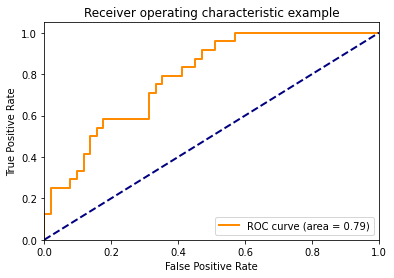

In [20]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)'%roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

<ipython-input-27-e763e5d235d6>:4: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


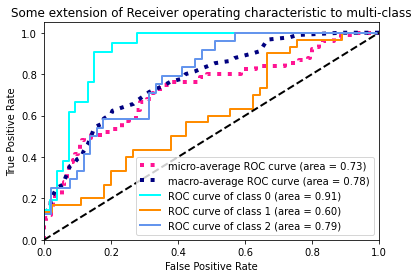

In [27]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label="micro-average ROC curve (area = {0:.2f})".format(roc_auc["micro"]),
         color='deeppink', linestyle=":", linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label="macro-average ROC curve (area = {0:.2f})".format(roc_auc["macro"]), 
        color='navy', linestyle=":", linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multi-class")
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X, y = load_breast_cancer(return_X_y=True)
clf = LogisticRegression(solver='liblinear').fit(X, y)
clf.classes_

array([0, 1])

In [22]:
y_score = clf.predict_proba(X)[:, 1]
roc_auc_score(y, y_score)

0.9947016542466043

In [23]:
roc_auc_score(y, clf.decision_function(X))

0.9947016542466043

In [24]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
X, y = make_multilabel_classification(random_state=0)
inner_clf = LogisticRegression(solver="liblinear", random_state=0)
clf = MultiOutputClassifier(inner_clf).fit(X, y)
y_score = np.transpose([y_pred[:, 1] for y_pred in clf.predict_proba(X)])
roc_auc_score(y, y_score, average=None)

array([0.82664884, 0.86034414, 0.94181818, 0.8502652 , 0.94809095])

In [33]:
from sklearn.linear_model import RidgeClassifierCV
clf = RidgeClassifierCV().fit(X, y)
roc_auc_score(y, y_score, average=None)

array([0.82664884, 0.86034414, 0.94181818, 0.8502652 , 0.94809095])

## Brier score loss and Zero One loss

In [34]:
from sklearn.metrics import zero_one_loss
y_pred = [1, 2, 3, 4]
y_true = [2, 2, 3, 4]
print(zero_one_loss(y_true, y_pred))
print(zero_one_loss(y_true, y_pred, normalize=False))

0.25
1


Optimal number of features: 3


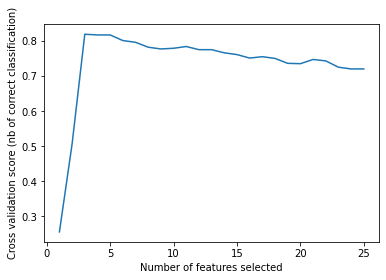

In [37]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3, n_redundant=2, n_repeated=0, n_classes=8,
                          n_clusters_per_class=1, random_state=0)
svc = SVC(kernel="linear")
min_features_to_select = 1
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring="accuracy",
              min_features_to_select=min_features_to_select)
rfecv.fit(X, y)
print("Optimal number of features: %d"%rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classification)")
plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
plt.show()

In [39]:
import numpy as np
from sklearn.metrics import brier_score_loss
y_true = np.array([0, 1, 1, 0])
y_true_categorical = np.array(['spam', 'ham', 'ham', 'spam'])
y_prob = np.array([0.1, 0.9, 0.8, 0.4])
y_pred = np.array([0, 1, 1, 0])
print(brier_score_loss(y_true, y_prob))
print(brier_score_loss(y_true, 1 - y_prob, pos_label=0))
print(brier_score_loss(y_true_categorical, y_prob, pos_label="ham"))
print(brier_score_loss(y_true, y_prob > 0.5))

0.055
0.055
0.055
0.0


# Multilabel Ranking metrics

## Coverage error

In [2]:
import numpy as np
from sklearn.metrics import coverage_error
y_true = np.array([[1, 0, 0], [0, 0, 1]])
y_score = np.array([[0.75, 0.5, 1], [1, 0.2, 0.1]])
coverage_error(y_true, y_score)

2.5

## Label ranking average precision score

In [4]:
import numpy as np
from sklearn.metrics import label_ranking_average_precision_score
y_true = np.array([[1, 0, 0], [0, 0, 1]])
y_score = np.array([[0.75, 0.5, 1], [1, 0.2, 0.1]])
label_ranking_average_precision_score(y_true, y_score)

0.41666666666666663

## label ranking loss

In [5]:
import numpy as np
from sklearn.metrics import label_ranking_loss
y_true = np.array([[1, 0, 0], [0, 0, 1]])
y_score = np.array([[0.75, 0.5, 1], [1, 0.2, 0.1]])
label_ranking_loss(y_true, y_score)

0.75

In [6]:
y_score = np.array([[1.0, 0.1, .2], [0.1, 0.2, 0.9]])
label_ranking_loss(y_true, y_score)

0.0

## dcg and ndcg score

In [8]:
from sklearn.metrics import dcg_score
true_relevance = np.asarray([[10, 0, 0, 1, 5]])
scores = np.array([[.1, .2, .3, 4, 70]])
print(dcg_score(true_relevance, scores))
print(dcg_score(true_relevance, scores, k= 2))
scores = np.asarray([[1, 0, 0, 0, 1]])
print(dcg_score(true_relevance, scores, k=1))
print(dcg_score(true_relevance, scores, k = 1, ignore_ties=True))

9.499457825916874
5.630929753571458
7.5
5.0


In [11]:
from sklearn.metrics import ndcg_score
true_relevance = np.asarray([[10, 0, 0, 1, 5]])
scores = np.asarray([[.05, 1.1, 1., .5, .0]])
print(ndcg_score(true_relevance, scores))
scores = np.asarray([[.05, 1.1, 1., .5, .0]])
print(ndcg_score(true_relevance, scores))
print(ndcg_score(true_relevance, scores, k=4))
print(ndcg_score(true_relevance, true_relevance, k = 4))
scores = np.asarray([[1, 0, 0, 0, 1]])
print(ndcg_score(true_relevance, scores, k=1))
print(ndcg_score(true_relevance, scores, k = 1, ignore_ties=True))

0.493680191377376
0.493680191377376
0.3520241100634488
1.0
0.75
0.5


# Regression Metrics

## explained variance score and Max error

In [15]:
from sklearn.metrics import explained_variance_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(explained_variance_score(y_true, y_pred))
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5], ]
print(explained_variance_score(y_true, y_pred, multioutput='raw_values'))
print(explained_variance_score(y_true, y_pred, multioutput=[0.3, 0.7]))

0.9571734475374732
[0.96774194 1.        ]
0.9903225806451612


In [16]:
from sklearn.metrics import max_error
y_true = [3, 2, 7, 1]
y_pred = [9, 2, 7, 2]
max_error(y_true, y_pred)

6

## Mean

In [17]:
from sklearn.metrics import mean_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(mean_absolute_error(y_true, y_pred))
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
print(mean_absolute_error(y_true, y_pred))
print(mean_absolute_error(y_true, y_pred, multioutput='raw_values'))
print(mean_absolute_error(y_true, y_pred, multioutput=[0.3, 0.7]))

0.5
0.75
[0.5 1. ]
0.85


In [19]:
from sklearn.metrics import mean_squared_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(mean_squared_error(y_true, y_pred))
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
mean_squared_error(y_true, y_pred)

0.375


0.7083333333333334

In [20]:
from sklearn.metrics import mean_squared_log_error
y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]
print(mean_squared_log_error(y_true, y_pred))
y_true = [[0.5, 1], [1, 2], [7, 6]]
y_pred = [[0.5, 2], [1, 2.5], [8, 8]]
print(mean_squared_log_error(y_true, y_pred))

0.03973012298459379
0.044199361889160536


In [24]:
from sklearn.metrics import median_absolute_error
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
median_absolute_error(y_true, y_pred)

0.5

## R2_score

In [2]:
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
print(r2_score(y_true, y_pred))
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
print(r2_score(y_true, y_pred, multioutput='variance_weighted'))
y_true = [[0.5, 1], [-1, 1], [7, -6]]
y_pred = [[0, 2], [-1, 2], [8, -5]]
print(r2_score(y_true, y_pred, multioutput="uniform_average"))
print(r2_score(y_true, y_pred, multioutput='raw_values'))
print(r2_score(y_true, y_pred, multioutput=[0.3, 0.7]))

0.9486081370449679
0.9382566585956417
0.9368005266622779
[0.96543779 0.90816327]
0.9253456221198156


## mean tweedie deviance

In [7]:
from sklearn.metrics import mean_tweedie_deviance
print(mean_tweedie_deviance([1.0], [1.5], power = 0))
mean_tweedie_deviance([100], [150], power = 0)

0.25


2500.0

In [8]:
print(mean_tweedie_deviance([1.0], [1.5], power = 1))
mean_tweedie_deviance([100], [150], power = 1)

0.18906978378367123


18.906978378367114

In [9]:
print(mean_tweedie_deviance([1.0], [1.5], power = 2))
mean_tweedie_deviance([100], [150], power = 2)

0.14426354954966225


0.14426354954966225

In [12]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
X, y = load_iris(return_X_y=True)
y[y != 1] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [14]:
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1).fit(X_train, y_train)
print(clf.score(X_test, y_test))
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.631578947368421


0.5789473684210527

In [15]:
clf = SVC(kernel="rbf", C = 1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9473684210526315

# Validate Curve and learning curve

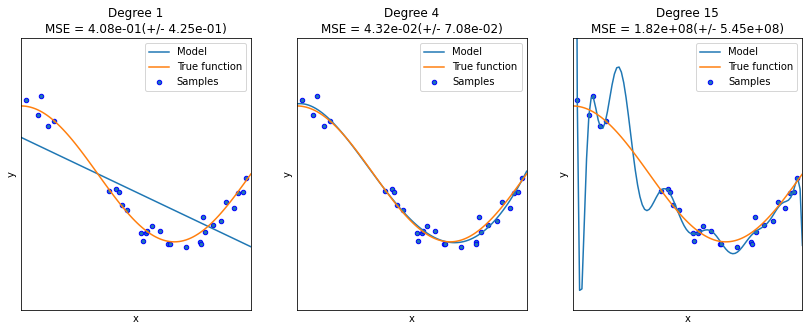

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
degrees = [1, 4, 15]
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    scores = cross_val_score(pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))
plt.show()

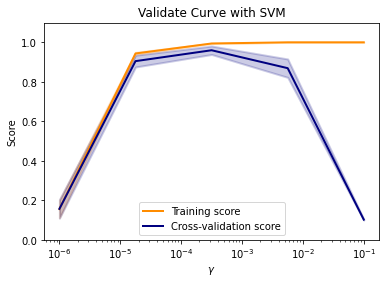

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

X, y = load_digits(return_X_y=True)
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(SVC(), X, y, param_name="gamma", param_range = param_range,
                                           scoring='accuracy', n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.title("Validate Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2,
                color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [26]:
train_scores_mean

array([0.80932498, 0.80765484, 0.8255911 , 0.82475661, 0.82726008])

Automatically created module for IPython interactive environment
[ 143  467  790 1113 1437]
[ 143  467  790 1113 1437]


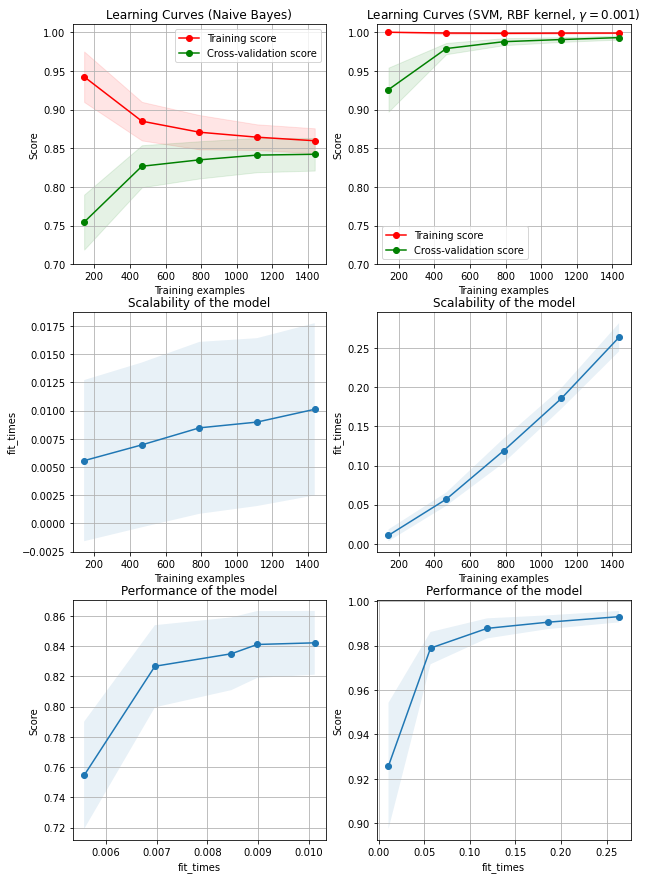

In [29]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    print(train_sizes)

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

In [31]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge
np.random.seed(0)
X, y = load_iris(return_X_y=True)
indices = np.arange(y.shape[0])
np.random.shuffle(indices)
X, y = X[indices], y[indices]
train_scores, valid_scores = validation_curve(Ridge(), X, y, param_name="alpha", param_range=np.logspace(-7, 3, 3), cv=5)
print(train_scores)
valid_scores

[[0.93402178 0.94366418 0.92648383 0.91933313 0.92922507]
 [0.9340217  0.94366412 0.92648377 0.91933304 0.929225  ]
 [0.51143526 0.52415737 0.49868907 0.47086988 0.49623503]]


array([[0.9055033 , 0.84185935, 0.94569793, 0.96231017, 0.93366144],
       [0.90550088, 0.84184574, 0.94568969, 0.96233172, 0.93366806],
       [0.46706558, 0.25698974, 0.50496293, 0.49826404, 0.52500014]])

In [34]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel="linear"), X, y, train_sizes=[50, 80, 110], cv=5)
print(train_sizes)
print(train_scores)
valid_scores

[ 50  80 110]
[[0.98       0.98       0.98       0.98       0.98      ]
 [0.9875     1.         0.9875     0.9875     0.9875    ]
 [0.98181818 1.         0.98181818 0.98181818 0.99090909]]


array([[1.        , 0.93333333, 1.        , 1.        , 0.96666667],
       [1.        , 0.96666667, 1.        , 1.        , 0.96666667],
       [1.        , 0.96666667, 1.        , 1.        , 0.96666667]])

# Preprocessing

## Standardization, or mean removal and variance

In [1]:
from sklearn import preprocessing
import numpy as np
X_train = np.array([[1, -1, 2],
                   [2, 0, 0],
                   [0, 1, -1]])
scaler = preprocessing.StandardScaler().fit(X_train)
print(scaler)
print(scaler.mean_)
print(scaler.scale_)
X_scaled = scaler.transform(X_train)
X_scaled

StandardScaler()
[1.         0.         0.33333333]
[0.81649658 0.81649658 1.24721913]


array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

In [3]:
print(X_scaled.mean(axis=0))
X_scaled.std(axis=0)

[0. 0. 0.]


array([1., 1., 1.])

In [4]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
print(pipe.fit(X_train, y_train))
pipe.score(X_test, y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])


0.96

In [5]:
#Scaling features to a range 
X_train = np.array([[1, -1, 2], 
                   [2, 0, 0],
                   [0, 1, -1]])
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_train_minmax

array([[0.5       , 0.        , 1.        ],
       [1.        , 0.5       , 0.33333333],
       [0.        , 1.        , 0.        ]])

In [7]:
X_test = np.array([[-3, -1, 4]])
X_test_minmax = min_max_scaler.transform(X_test)
X_test_minmax

array([[-1.5       ,  0.        ,  1.66666667]])

In [8]:
print(min_max_scaler.scale_)
min_max_scaler.min_

[0.5        0.5        0.33333333]


array([0.        , 0.5       , 0.33333333])

In [9]:
#Formaula
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

In [11]:
X_train = np.array([[1, -1, 2],
                   [2, 0, 0],
                   [0, 1, -1]])
max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_maxabs = max_abs_scaler.fit_transform(X_train)
print(X_train_maxabs)
X_test = np.array([[-3, -1, 4]])
X_test_maxabs = max_abs_scaler.transform(X_test)
print(X_test_maxabs)
max_abs_scaler.scale_

[[ 0.5 -1.   1. ]
 [ 1.   0.   0. ]
 [ 0.   1.  -0.5]]
[[-1.5 -1.   2. ]]


array([2., 1., 2.])

In [15]:
from sklearn.preprocessing import RobustScaler
X = [[1, -2, 2],
    [-2, 1, 3],
    [4, 1, -2]]
transformer = RobustScaler().fit(X)
print(transformer)
transformer.transform(X)

RobustScaler()


array([[ 0. , -2. ,  0. ],
       [-1. ,  0. ,  0.4],
       [ 1. ,  0. , -1.6]])

In [19]:
from sklearn.preprocessing import KernelCenterer
from sklearn.metrics.pairwise import pairwise_kernels
X = [[1, -2, 2],
    [-2, 1, 3],
    [4, 1, -2]]
K = pairwise_kernels(X, metric='linear')
print(K)
transformer = KernelCenterer().fit(K)
print(transformer)
transformer.transform(K)

[[  9.   2.  -2.]
 [  2.  14. -13.]
 [ -2. -13.  21.]]
KernelCenterer()


array([[  5.,   0.,  -5.],
       [  0.,  14., -14.],
       [ -5., -14.,  19.]])

## Non-linear transformation

In [22]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
X, y = load_iris(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
quantile_transformer = preprocessing.QuantileTransformer(random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train)
X_test_trans = quantile_transformer.transform(X_test)
np.percentile(X_train[:, 0], [0, 25, 50, 75, 100])

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\preprocessing\_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


array([4.3, 5.1, 5.8, 6.5, 7.9])

In [23]:
np.percentile(X_train_trans[:, 0], [0, 25, 50, 75, 100])

array([0.        , 0.23873874, 0.50900901, 0.74324324, 1.        ])

In [24]:
print(np.percentile(X_test[:, 0], [0, 25, 50, 75, 100]))
np.percentile(X_test_trans[:, 0], [0, 25, 50, 75, 100])

[4.4   5.125 5.75  6.175 7.3  ]


array([0.01351351, 0.25      , 0.47747748, 0.60472973, 0.94144144])

In [26]:
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
X_lognormal = np.random.RandomState(616).lognormal(size=(3, 3))
print(X_lognormal)
pt.fit_transform(X_lognormal)

[[1.28331718 1.18092228 0.84160269]
 [0.94293279 1.60960836 0.3879099 ]
 [1.35235668 0.21715673 1.09977091]]


array([[ 0.49024349,  0.17881995, -0.1563781 ],
       [-0.05102892,  0.58863195, -0.57612414],
       [ 0.69420009, -0.84857822,  0.10051454]])

In [27]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
X_trans = quantile_transformer.fit_transform(X)
quantile_transformer.quantiles_

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\preprocessing\_data.py:2367: UserWarning: n_quantiles (1000) is greater than the total number of samples (150). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


array([[4.3, 2. , 1. , 0.1],
       [4.4, 2.2, 1.1, 0.1],
       [4.4, 2.2, 1.2, 0.1],
       [4.4, 2.2, 1.2, 0.1],
       [4.5, 2.3, 1.3, 0.1],
       [4.6, 2.3, 1.3, 0.2],
       [4.6, 2.3, 1.3, 0.2],
       [4.6, 2.3, 1.3, 0.2],
       [4.6, 2.4, 1.3, 0.2],
       [4.7, 2.4, 1.3, 0.2],
       [4.7, 2.4, 1.3, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.8, 2.5, 1.4, 0.2],
       [4.9, 2.5, 1.4, 0.2],
       [4.9, 2.5, 1.4, 0.2],
       [4.9, 2.5, 1.4, 0.2],
       [4.9, 2.6, 1.4, 0.2],
       [4.9, 2.6, 1.4, 0.2],
       [4.9, 2.6, 1.4, 0.2],
       [5. , 2.6, 1.4, 0.2],
       [5. , 2.6, 1.4, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5. , 2.7, 1.5, 0.2],
       [5.1, 2.7, 1.5, 0.2],
       [5.1, 2.8, 1.5, 0.2],
       [5.1, 2

# Normalization

In [2]:
from sklearn.preprocessing import Normalizer
X = [[4, 1, 2, 2],
    [1, 3, 9, 3],
    [5, 7, 5, 1]]
transformer = Normalizer().fit(X)
print(transformer)
transformer.transform(X)

Normalizer()


array([[0.8, 0.2, 0.4, 0.4],
       [0.1, 0.3, 0.9, 0.3],
       [0.5, 0.7, 0.5, 0.1]])

In [3]:
from sklearn import preprocessing
X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1, -1]]
X_normalized = preprocessing.normalize(X, norm="l2")
X_normalized

array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678]])

In [4]:
normalizer = preprocessing.Normalizer().fit(X)
normalizer

Normalizer()

In [5]:
normalizer.transform(X)

array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678]])

In [6]:
normalizer.transform([[-1, 1, 0]])

array([[-0.70710678,  0.70710678,  0.        ]])

# Encoding Categorical Features

In [7]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
X = [["Male", 1], ['Female', 3], ["Female", 2]]
enc.fit(X)
enc.categories_

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]

In [8]:
enc.transform([["Female", 3], ["Male", 1]])

array([[0., 2.],
       [1., 0.]])

In [9]:
enc.inverse_transform([[1, 0], [0, 1]])

array([['Male', 1],
       ['Female', 2]], dtype=object)

In [12]:
enc = preprocessing.OrdinalEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
enc.fit(X)
enc.transform([['female', 'from US',  "uses Safari"]])

array([[0., 1., 1.]])

In [18]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ["Female", 2]]
print(enc.fit(X))
print(enc.categories_)
enc.transform([['Female', 1], ['Male', 4]]).toarray()

OneHotEncoder(handle_unknown='ignore')
[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]


array([[1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])

array([['Male', 1],
       [None, 2]], dtype=object)

In [22]:
drop_enc = OneHotEncoder(drop="first").fit(X)
drop_enc.categories_

[array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]

In [24]:
drop_enc.transform([['Female', 1], ["Male", 2]]).toarray()

array([[0., 0., 0.],
       [1., 1., 0.]])

In [26]:
drop_binary_enc = OneHotEncoder(drop='if_binary').fit(X)
drop_binary_enc.transform([['Female', 1], ['Male', 2]]).toarray()

array([[0., 1., 0., 0.],
       [1., 0., 1., 0.]])

In [28]:
enc = preprocessing.OneHotEncoder()
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
print(enc.fit(X))
enc.transform([['female', 'from US', 'uses Safari'], ['male', 'from Europe', 'uses Safari']]).toarray()

OneHotEncoder()


array([[1., 0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0., 1.]])

In [29]:
enc.categories_

[array(['female', 'male'], dtype=object),
 array(['from Europe', 'from US'], dtype=object),
 array(['uses Firefox', 'uses Safari'], dtype=object)]

In [31]:
genders = ['female', 'male']
locations = ['from Africa', 'from Asia', 'from Europe', 'from US']
browsers = ['uses Chrome', 'uses Firefox', 'uses IE', 'uses Safari']
enc = preprocessing.OneHotEncoder(categories=[genders, locations, browsers])
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
print(enc.fit(X))
enc.transform([['female', 'from Asia', 'uses Chrome']]).toarray()

OneHotEncoder(categories=[['female', 'male'],
                          ['from Africa', 'from Asia', 'from Europe',
                           'from US'],
                          ['uses Chrome', 'uses Firefox', 'uses IE',
                           'uses Safari']])


array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]])

In [32]:
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
print(enc.fit(X))
enc.transform([['female', 'from Asia', 'uses Chrome']]).toarray()

OneHotEncoder(handle_unknown='ignore')


array([[1., 0., 0., 0., 0., 0.]])

In [33]:
X = [['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox']]
drop_enc = preprocessing.OneHotEncoder(drop='first').fit(X)
print(drop_enc.categories_)
drop_enc.transform(X).toarray()

[array(['female', 'male'], dtype=object), array(['from Europe', 'from US'], dtype=object), array(['uses Firefox', 'uses Safari'], dtype=object)]


array([[1., 1., 1.],
       [0., 0., 0.]])

In [36]:
X = [['male', 'US', "Safari"],['female', 'Europe', 'Firefox'], ['female', 'Asia', 'Chrome']]
drop_enc = preprocessing.OneHotEncoder(drop="if_binary").fit(X)
print(drop_enc.categories_)
drop_enc.transform(X).toarray()

[array(['female', 'male'], dtype=object), array(['Asia', 'Europe', 'US'], dtype=object), array(['Chrome', 'Firefox', 'Safari'], dtype=object)]


array([[1., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 0.]])

In [38]:
drop_enc = preprocessing.OneHotEncoder(handle_unknown='ignore').fit(X)
X_test = [['unknown', 'America', 'IE']]
drop_enc.transform(X_test).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0.]])

# Discretization

In [43]:
X = np.array([[-3, 5, 15],
             [0, 6, 14],
             [6, 3, 11]])
est = preprocessing.KBinsDiscretizer(n_bins=[3, 2, 2], encode='ordinal').fit(X)

In [44]:
est.transform(X)

array([[0., 1., 1.],
       [1., 1., 1.],
       [2., 0., 0.]])

In [49]:
import pandas as pd
import numpy as np
bins = [0, 1, 13, 20, 60, np.inf]
labels = ['infant', 'kid', 'teen', 'adult', 'senior citizen']
transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={'bins':bins, 'labels':labels, 'retbins':False})
X = np.array([0.2, 2, 15, 25, 97])
transformer.fit_transform(X)

['infant', 'kid', 'teen', 'adult', 'senior citizen']
Categories (5, object): ['infant' < 'kid' < 'teen' < 'adult' < 'senior citizen']

Automatically created module for IPython interactive environment


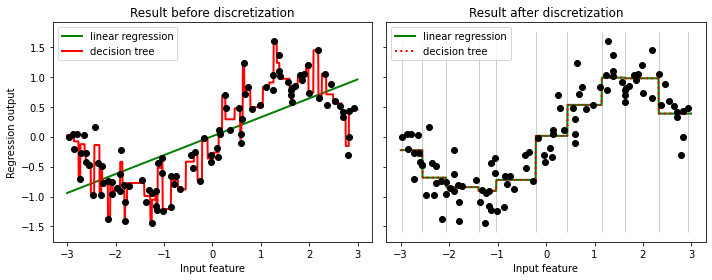

In [50]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeRegressor

print(__doc__)

# construct the dataset
rnd = np.random.RandomState(42)
X = rnd.uniform(-3, 3, size=100)
y = np.sin(X) + rnd.normal(size=len(X)) / 3
X = X.reshape(-1, 1)

# transform the dataset with KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=10, encode='onehot')
X_binned = enc.fit_transform(X)

# predict with original dataset
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)
reg = LinearRegression().fit(X, y)
ax1.plot(line, reg.predict(line), linewidth=2, color='green',
         label="linear regression")
reg = DecisionTreeRegressor(min_samples_split=3, random_state=0).fit(X, y)
ax1.plot(line, reg.predict(line), linewidth=2, color='red',
         label="decision tree")
ax1.plot(X[:, 0], y, 'o', c='k')
ax1.legend(loc="best")
ax1.set_ylabel("Regression output")
ax1.set_xlabel("Input feature")
ax1.set_title("Result before discretization")

# predict with transformed dataset
line_binned = enc.transform(line)
reg = LinearRegression().fit(X_binned, y)
ax2.plot(line, reg.predict(line_binned), linewidth=2, color='green',
         linestyle='-', label='linear regression')
reg = DecisionTreeRegressor(min_samples_split=3,
                            random_state=0).fit(X_binned, y)
ax2.plot(line, reg.predict(line_binned), linewidth=2, color='red',
         linestyle=':', label='decision tree')
ax2.plot(X[:, 0], y, 'o', c='k')
ax2.vlines(enc.bin_edges_[0], *plt.gca().get_ylim(), linewidth=1, alpha=.2)
ax2.legend(loc="best")
ax2.set_xlabel("Input feature")
ax2.set_title("Result after discretization")

plt.tight_layout()
plt.show()

Automatically created module for IPython interactive environment


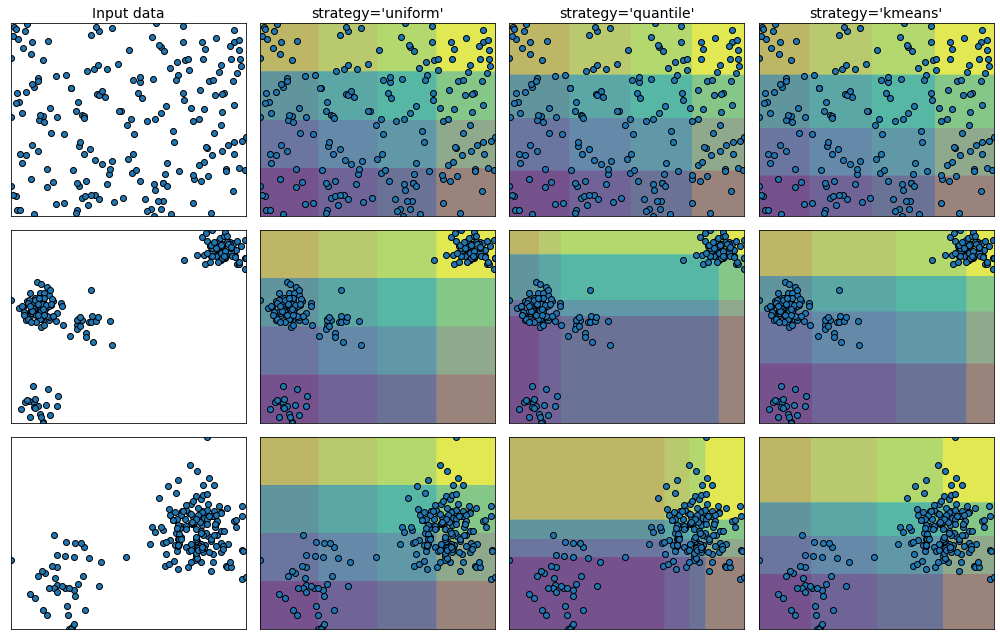

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.datasets import make_blobs

print(__doc__)

strategies = ['uniform', 'quantile', 'kmeans']

n_samples = 200
centers_0 = np.array([[0, 0], [0, 5], [2, 4], [8, 8]])
centers_1 = np.array([[0, 0], [3, 1]])

# construct the datasets
random_state = 42
X_list = [
    np.random.RandomState(random_state).uniform(-3, 3, size=(n_samples, 2)),
    make_blobs(n_samples=[n_samples // 10, n_samples * 4 // 10,
                          n_samples // 10, n_samples * 4 // 10],
               cluster_std=0.5, centers=centers_0,
               random_state=random_state)[0],
    make_blobs(n_samples=[n_samples // 5, n_samples * 4 // 5],
               cluster_std=0.5, centers=centers_1,
               random_state=random_state)[0],
]

figure = plt.figure(figsize=(14, 9))
i = 1
for ds_cnt, X in enumerate(X_list):

    ax = plt.subplot(len(X_list), len(strategies) + 1, i)
    ax.scatter(X[:, 0], X[:, 1], edgecolors='k')
    if ds_cnt == 0:
        ax.set_title("Input data", size=14)

    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), 300),
        np.linspace(X[:, 1].min(), X[:, 1].max(), 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    i += 1
    # transform the dataset with KBinsDiscretizer
    for strategy in strategies:
        enc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy=strategy)
        enc.fit(X)
        grid_encoded = enc.transform(grid)

        ax = plt.subplot(len(X_list), len(strategies) + 1, i)

        # horizontal stripes
        horizontal = grid_encoded[:, 0].reshape(xx.shape)
        ax.contourf(xx, yy, horizontal, alpha=.5)
        # vertical stripes
        vertical = grid_encoded[:, 1].reshape(xx.shape)
        ax.contourf(xx, yy, vertical, alpha=.5)

        ax.scatter(X[:, 0], X[:, 1], edgecolors='k')
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title("strategy='%s'" % (strategy, ), size=14)

        i += 1

plt.tight_layout()
plt.show()

In [54]:
X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1, -1]]
binarizer = preprocessing.Binarizer().fit(X)
print(binarizer)
binarizer.transform(X)

Binarizer()


array([[1, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [55]:
binarizer = preprocessing.Binarizer(threshold=1.1)
binarizer.transform(X)

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 0]])

# Generating Polynomial Features

In [56]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [57]:
poly = PolynomialFeatures(2)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [58]:
X = np.arange(9).reshape(3, 3)
X

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [59]:
poly = PolynomialFeatures(degree = 3, interaction_only=True)
poly.fit_transform(X)

array([[  1.,   0.,   1.,   2.,   0.,   0.,   2.,   0.],
       [  1.,   3.,   4.,   5.,  12.,  15.,  20.,  60.],
       [  1.,   6.,   7.,   8.,  42.,  48.,  56., 336.]])

# Custom transformers

In [63]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)
X = np.array([[0, 1], [2, 3]])
transformer.transform(X)

array([[0.        , 0.69314718],
       [1.09861229, 1.38629436]])

# Gaussian Mixture Models

In [4]:
import numpy as np
from sklearn.mixture import GaussianMixture
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
gm = GaussianMixture(n_components=2, random_state=0).fit(X)
print(gm.means_)
gm.predict([[0, 0], [12, 3]])

[[10.  2.]
 [ 1.  2.]]


array([1, 0], dtype=int32)

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


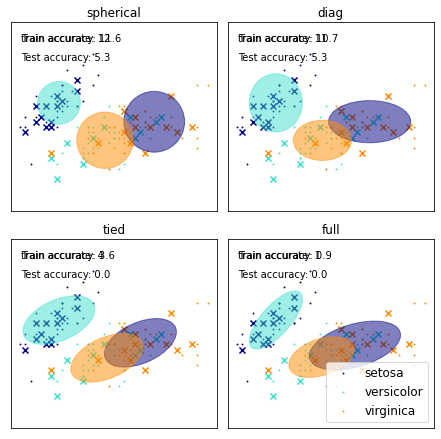

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
colors = ['navy', 'turquoise', 'darkorange']
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi
        v = 2. * np.sqrt(2) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()
skf = StratifiedKFold(n_splits=4)
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))
X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]
n_classes = len(np.unique(y_train))
estimators = {cov_type: GaussianMixture(n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}
n_estimators = len(estimators)
plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=0.01, top=0.95, hspace=.15, wspace=.05, left=.01, right=.99)
for index, (name, estimator) in enumerate(estimators.items()):
    estimator.mean_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])
    estimator.fit(X_train)
    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)
    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n])
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'train accurate: %1.f'%train_accuracy, transform=h.transAxes)
    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f'%train_accuracy, transform = h.transAxes)
    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f'%test_accuracy, transform = h.transAxes)
    plt.xticks(())
    plt.yticks(())
    plt.title(name)
plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.show()

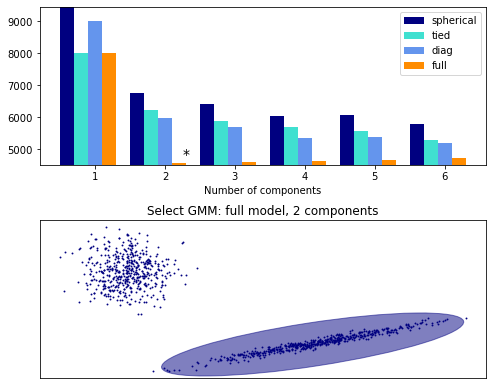

In [22]:
import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mlp
from sklearn import mixture
n_samples = 500
np.random.seed(0)
C = np.array([[0, -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C), .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange'])
vlf = best_gmm
bars = []
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range): (i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 + .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + 0.03 *  bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)
plt.xticks(())
plt.yticks(())
plt.title(f'Select GMM: {best_gmm.covariance_type} model, 'f'{best_gmm.n_components} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

## Bayesian Gaussian Mixture

In [24]:
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [12, 4], [10, 7]])
bgm = BayesianGaussianMixture(n_components=2, random_state=42).fit(X)
print(bgm.means_)
bgm.predict([[0, 0], [9, 3]])

[[2.4975536  2.29225365]
 [8.45533127 4.5225831 ]]


array([0, 1], dtype=int32)

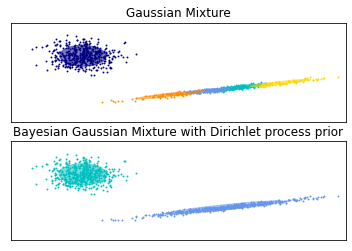

In [25]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(-9, 5)
    plt.ylim(-3, 6)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

n_samples = 500
np.random.seed(0)
C = np.array([[0, -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C), .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')
dpgmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with Dirichlet process prior')
plt.show()

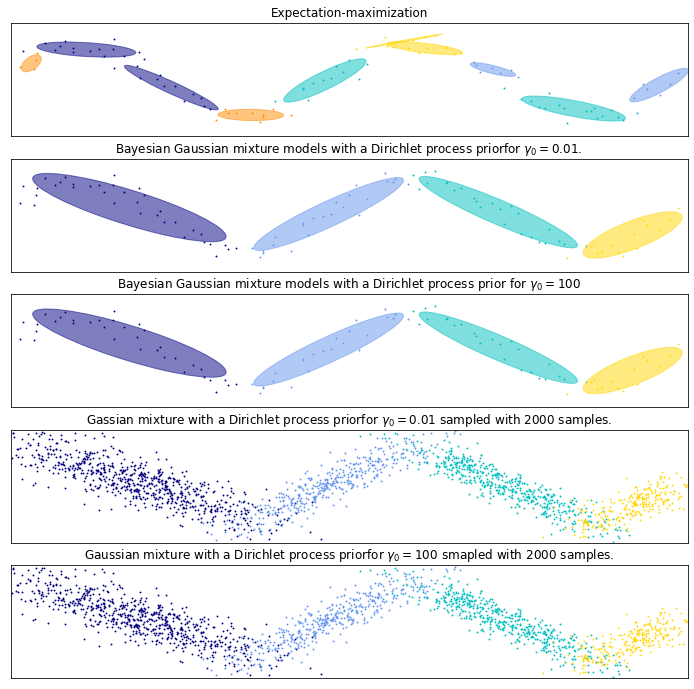

In [9]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])
def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(-6, 4 * np.pi - 6)
    plt.ylim(-5, 5)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())
    
def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)
    plt.xlim(-6, 4 * np.pi - 6)
    plt.ylim(-5, 5)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

n_samples = 100
np.random.seed(0)
X = np.zeros((n_smaples, 2))
step = 4 * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(bottom=.04, top=.95, hspace=.2, wspace=.05, left=.03, right=.97)
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full', max_iter=100).fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Expectation-maximization')
dpgmm = mixture.BayesianGaussianMixture(n_components=10, covariance_type = 'full', weight_concentration_prior=1e-2, 
                                       weight_concentration_prior_type='dirichlet_process', mean_precision_prior=1e-2, 
                                       covariance_prior=1e0 * np.eye(2), init_params = "random", max_iter=100, 
                                        random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1, "Bayesian Gaussian mixture models with a Dirichlet"+
             " process prior"r"for $\gamma_0=0.01$.")
X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 0, "Gassian mixture with a Dirichlet process prior"
            r"for $\gamma_0 = 0.01$ sampled with $2000$ samples.")
gpgmm = mixture.BayesianGaussianMixture(n_components=10, covariance_type='full', weight_concentration_prior=1e+2, 
                                       weight_concentration_prior_type='dirichlet_process', covariance_prior=1e0 * np.eye(2),
                                       init_params="kmeans", max_iter=100, random_state=2, mean_precision_prior=1e-2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2, "Bayesian Gaussian mixture models with a Dirichlet"+
             " process prior "r"for $\gamma_0=100$")
X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 1, "Gaussian mixture with a Dirichlet process prior"r"for $\gamma_0 = 100$"+
             " smapled with $2000$ samples.")
plt.show()

Automatically created module for IPython interactive environment


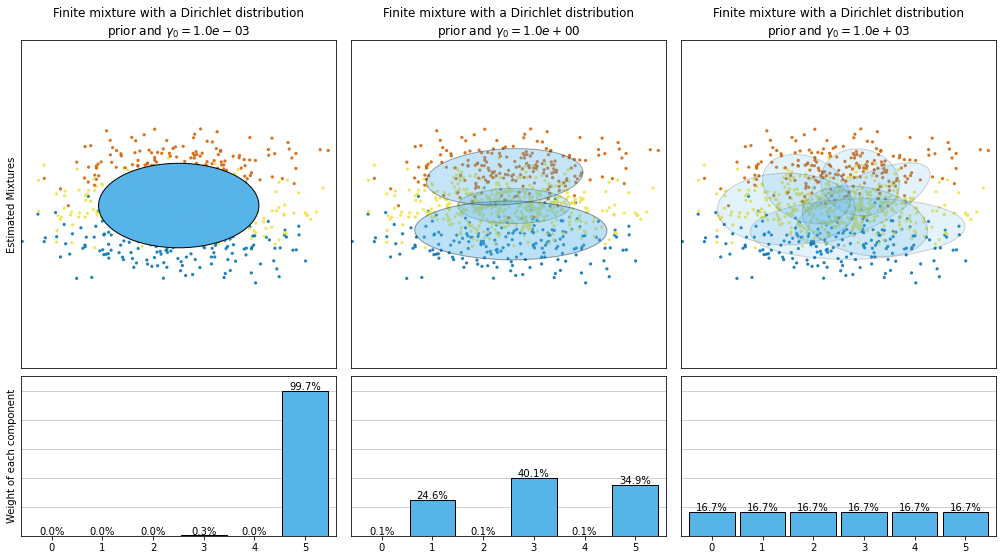

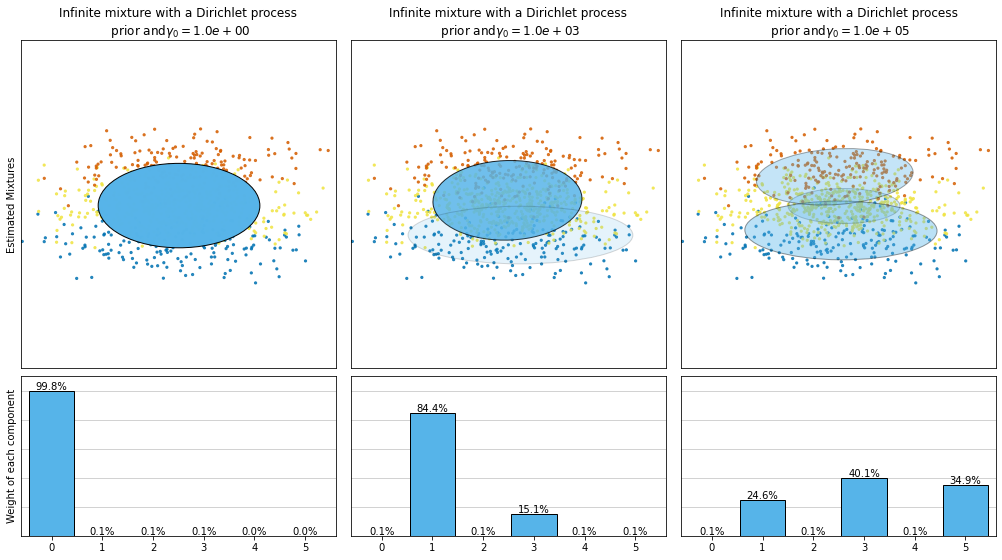

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.mixture import BayesianGaussianMixture

print(__doc__)


def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker='o', color=colors[y], alpha=0.8)
    ax1.set_xlim(-2., 2.)
    ax1.set_ylim(-3., 3.)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_,
                  estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
                align='center', edgecolor='black')
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),
                 horizontalalignment='center')
    ax2.set_xlim(-.6, 2 * n_components - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left=False,
                    right=False, labelleft=False)
    ax2.tick_params(axis='x', which='both', top=False)

    if plot_title:
        ax1.set_ylabel('Estimated Mixtures')
        ax2.set_ylabel('Weight of each component')


# Parameters of the dataset
random_state, n_components, n_features = 2, 3, 2
colors = np.array(['#0072B2', '#F0E442', '#D55E00'])

covars = np.array([[[.7, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]]])
samples = np.array([200, 500, 200])
means = np.array([[.0, -.70],
                  [.0, .0],
                  [.0, .70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    ("Finite mixture with a Dirichlet distribution\nprior and "
     r"$\gamma_0=$", BayesianGaussianMixture(
         weight_concentration_prior_type="dirichlet_distribution",
         n_components=2 * n_components, reg_covar=0, init_params='random',
         max_iter=1500, mean_precision_prior=.8,
         random_state=random_state), [0.001, 1, 1000]),
    ("Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
     BayesianGaussianMixture(
         weight_concentration_prior_type="dirichlet_process",
         n_components=2 * n_components, reg_covar=0, init_params='random',
         max_iter=1500, mean_precision_prior=.8,
         random_state=random_state), [1, 1000, 100000])]

# Generate data
rng = np.random.RandomState(random_state)
X = np.vstack([
    rng.multivariate_normal(means[j], covars[j], samples[j])
    for j in range(n_components)])
y = np.concatenate([np.full(samples[j], j, dtype=int)
                    for j in range(n_components)])

# Plot results in two different figures
for (title, estimator, concentrations_prior) in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                        left=.03, right=.99)

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(plt.subplot(gs[0:2, k]), plt.subplot(gs[2, k]), estimator,
                     X, y, r"%s$%.1e$" % (title, concentration),
                     plot_title=k == 0)

plt.show()

# Manifold Leaning

## Isomap

In [11]:
from sklearn.datasets import load_digits
from sklearn.manifold import Isomap
X, _ = load_digits(return_X_y = True)
print(X.shape)
embedding = Isomap(n_components=2)
X_transfromed = embedding.fit_transform(X[:100])
X_transfromed.shape

(1797, 64)


(100, 2)

In [12]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
n_neighbors = 30

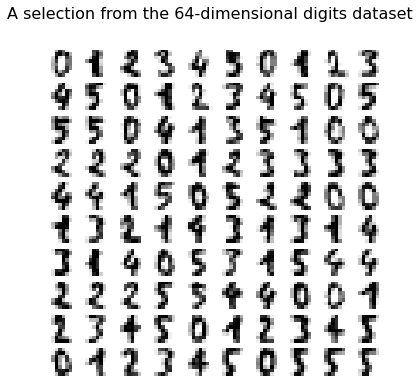

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis('off')
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [25]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler
def plot_embedding(X, title, ax):
    X = MinMaxScaler().fit_transform(X)
    shown_images = np.array([[1, 1]])
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Dark2(y[i]), fontdict={"weight": "bold", "size":9})
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i])
        ax.add_artist(imagebox)
    ax.set_title(title)
    ax.axis("off")

In [26]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding, TSNE)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection
embeddings = {
    "Random projection embedding": SparseRandomProjection(n_components=2, random_state=42),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(n_components=2),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embeding": LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method="standard"),
    "Modified LLE embedding": LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method="modified"),
    "Hessian LLE embedding": LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method="hessian"),
    "LTSA LLE embedding": LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2, method="ltsa"),
    "MDS embedding": MDS(n_components=2, n_init=1, max_iter=100),
    "Random Trees embedding": make_pipeline(RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0), 
                                           TruncatedSVD(n_components=2)),
    "Spectral embedding": SpectralEmbedding(n_components=2, random_state=0, eigen_solver="arpack"),
    "t-SNE embedding": TSNE(n_components=2, init="pca", learning_rate="auto", random_state=0),
#     "NCA embedding": NeighborhoodComponentsAnalysis(n_components=2, init="random", random_state=0)
}

In [27]:
from time import time
projections, timing = {}, {}
for name, tranformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[::X.shape[1] + 1] += 0.01
    else:
        data = X
    print(f"Computing {name}...")
    start_time = time()
    projections[name] = tranformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embeding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...
Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embedding...


UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U4'), dtype('float32')) -> None

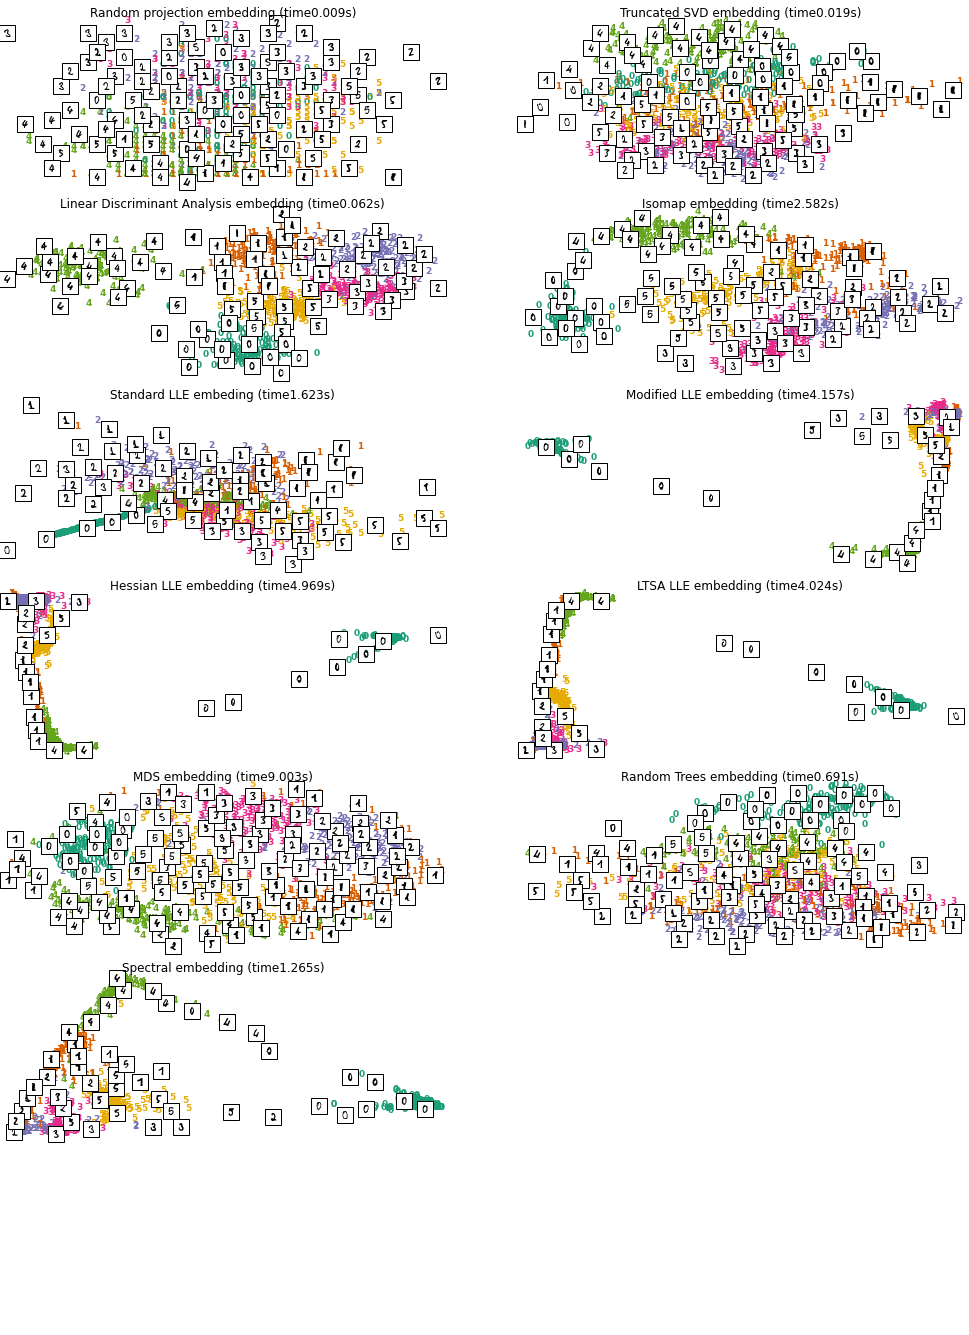

In [28]:
from itertools import zip_longest
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(17, 24))
for name, ax in zip_longest(timing, axs.ravel()):
    if name is None:
        ax.axis("off")
        continue
    title = f"{name} (time{timing[name]:.3f}s)"
    plot_embedding(projections[name], title, ax)
    
plt.show()

## Locally Linear Embedding

In [30]:
from sklearn.datasets import load_digits
from sklearn.manifold import LocallyLinearEmbedding
X, _ = load_digits(return_X_y=True)
print(X.shape)
embedding = LocallyLinearEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X)
X_transformed.shape

(1797, 64)


(1797, 2)

Done. Reconstruction error: 1.06914e-07


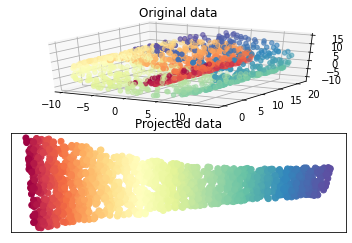

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets 
X, color=datasets.make_swiss_roll(n_samples=1500)
X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12, n_components=2)
print("Done. Reconstruction error: %g" %err)
fig = plt.figure()
ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")
ax = fig.add_subplot(212)
ax.scatter(X_r[:, 0], X_r[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis("tight")
plt.xticks([]), plt.yticks([])
plt.title("Projected data")
plt.show()

## Spectral embedding

In [1]:
from sklearn.datasets import load_digits
from sklearn.manifold import SpectralEmbedding
X, _ = load_digits(return_X_y=True)
print(X.shape)
embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X[:100])
X_transformed.shape

(1797, 64)


(100, 2)

## MDS

In [3]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
X, _ = load_digits(return_X_y = True)
print(X.shape)
embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X[:100])
X_transformed.shape

(1797, 64)


(100, 2)

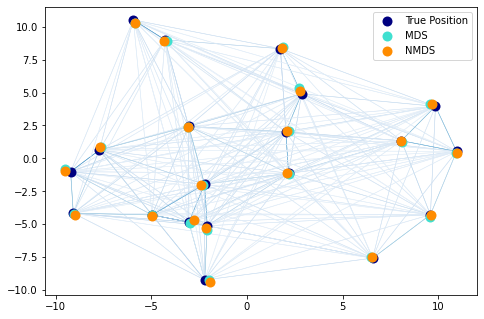

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
EPSILON = np.finfo(np.float32).eps
n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2*n_samples).astype(float)
X_true = X_true.reshape((n_samples, 2))
X_true -= X_true.mean()

similarities = euclidean_distances(X_true)
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
similarities += noise
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity = "precomputed",
                    n_jobs = 1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", 
                   random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)
pos = clf.fit_transform(pos)
npos = clf.fit_transform(npos)
fig = plt.figure(1)
ax = plt.axes([0, 0, 1, 1])
s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color="navy", s=s, lw=0, label="True Position")
plt.scatter(pos[:, 0], pos[:, 1], color="turquoise", s=s, lw=0, label='MDS')
plt.scatter(npos[:, 0], npos[:, 1], color="darkorange", s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)
similarities = similarities.max() / (similarities + EPSILON) * 100
np.fill_diagonal(similarities, 0)
start_idx, end_idx = np.where(pos)
segments = [[X_true[i, :], X_true[j, :]] for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments, zorder=0, cmap=plt.cm.Blues, norm = plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)
plt.show()

## TSNE

In [15]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, init="random").fit_transform(X)
X_embedded.shape

(4, 2)

# Biclustering

Consensus score: 1.000


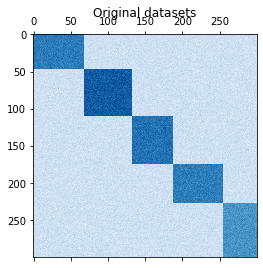

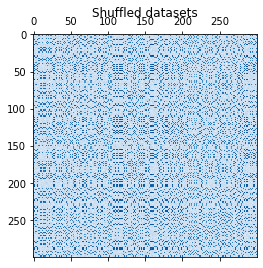

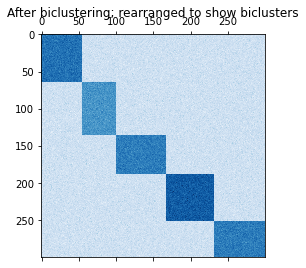

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score
data, rows, columns = make_biclusters(shape=(300, 300), n_clusters=5, noise=5, shuffle=False, random_state=0)
plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original datasets")
rng = np.random.RandomState(0)
row_idx = rng.permutation(data.shape[0])
col_idx = rng.permutation(data.shape[1])
data = data[row_idx][:, col_idx]
plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Shuffled datasets")
model = SpectralCoclustering(n_clusters=5, random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_, (rows[:, row_idx], columns[:, col_idx]))
print("Consensus score: {:.3f}".format(score))
fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.show()

# Covariance estimation

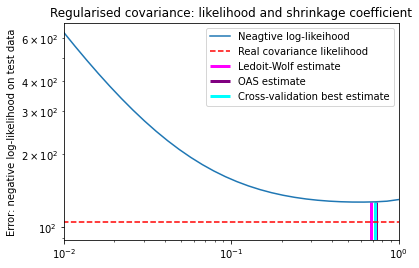

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.covariance import LedoitWolf, OAS, ShrunkCovariance, log_likelihood, empirical_covariance
from sklearn.model_selection import GridSearchCV
n_features, n_samples = 40, 20
np.random.seed(42)
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test = np.random.normal(size=(n_samples, n_features))
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train = np.dot(base_X_train, coloring_matrix)
X_test = np.dot(base_X_test, coloring_matrix)


shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test) for s in shrinkages]

real_cov = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov = empirical_covariance(X_train)
loglik_real = -log_likelihood(emp_cov, linalg.inv(real_cov))

tuned_parameters = [{'shrinkage':shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

lw = LedoitWolf()
loglik_lw = lw.fit(X_train).score(X_test)

oa = OAS()
loglik_oa = oa.fit(X_train).score(X_test)

fig = plt.figure()
plt.title("Regularised covariance: likelihood and shrinkage coefficient")
plt.ylabel("Regularization parameter: shrinkage coefficient")
plt.ylabel("Error: negative log-likelihood on test data")

plt.loglog(shrinkages, negative_logliks, label="Neagtive log-likeihood")
plt.plot(plt.xlim(), 2 * [loglik_real], '--r', label="Real covariance likelihood")

lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin = lik_min - 6 * np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax = lik_max + 10 * np.log(lik_max - lik_min)
xmin = shrinkages[0]
xmax = shrinkages[-1]
plt.vlines(lw.shrinkage_, ymin, -loglik_lw, color='magenta', linewidth=3, label='Ledoit-Wolf estimate')
plt.vlines(oa.shrinkage_, ymin, -loglik_lw, color='purple', linewidth=3, label='OAS estimate')
plt.vlines(cv.best_estimator_.shrinkage, ymin, -cv.best_estimator_.score(X_test), color='cyan', linewidth=3, 
           label='Cross-validation best estimate')
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()
plt.show()

In [9]:
import numpy as np
from sklearn.covariance import EmpiricalCovariance
from sklearn.datasets import make_gaussian_quantiles
real_cov = np.array([[.8, .3], [.3, .4]])
rng = np.random.RandomState(0)
X = rng.multivariate_normal(mean = [0, 0], cov=real_cov, size=500)
cov = EmpiricalCovariance().fit(X)
print(cov.covariance_)
cov.location_

[[0.75693565 0.28186631]
 [0.28186631 0.39288421]]


array([0.06228968, 0.01937939])

In [10]:
import numpy as np
from sklearn.covariance import LedoitWolf
real_cov = np.array([[.4, .2],
                    [.2, .8]])
np.random.seed(0)
X = np.random.multivariate_normal(mean=[0, 0], cov=real_cov, size=50)
cov = LedoitWolf().fit(X)
print(cov.covariance_)
cov.location_

[[0.44067332 0.16161585]
 [0.16161585 0.80226294]]


array([ 0.0595348 , -0.00756804])

In [11]:
import numpy as np
from sklearn.covariance import OAS
from sklearn.datasets import make_gaussian_quantiles
real_cov = np.array([[.8, .3],
                    [.3, .4]])
rng = np.random.RandomState(0)
X = rng.multivariate_normal(mean = [0, 0], cov=real_cov, size=500)
oas = OAS().fit(X)
print(oas.covariance_)
oas.precision_

[[0.75337235 0.27634855]
 [0.27634855 0.39644751]]


array([[ 1.78335694, -1.2431106 ],
       [-1.2431106 ,  3.38892735]])

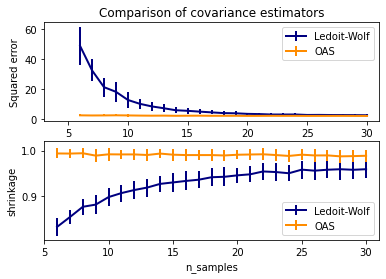

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky
from sklearn.covariance import LedoitWolf, OAS
np.random.seed(0)
n_features = 100
r = 0.1
real_cov = toeplitz(r ** np.arange(n_features))
coloring_matrix = cholesky(real_cov)
n_samples_range = np.arange(6, 31, 1)
repeat = 100
lw_mse = np.zeros((n_samples_range.size, repeat))
oa_mse = np.zeros((n_samples_range.size, repeat))
lw_shrinkage = np.zeros((n_samples_range.size, repeat))
oa_shrinkage = np.zeros((n_samples_range.size, repeat))
for i, n_samples in enumerate(n_samples_range):
    for j in range(repeat):
        X = np.dot(np.random.normal(size=(n_samples, n_features)), coloring_matrix.T)
        lw = LedoitWolf(store_precision=False, assume_centered=True)
        lw.fit(X)
        lw_mse[i, j] = lw.error_norm(real_cov, scaling=False)
        lw_shrinkage[i, j] = lw.shrinkage_
        oa = OAS(store_precision=False, assume_centered=True)
        oa.fit(X)
        oa_mse[i, j] = oa.error_norm(real_cov, scaling=False)
        oa_shrinkage[i, j] = oa.shrinkage_
plt.subplot(2, 1, 1)
plt.errorbar(n_samples_range, lw_mse.mean(1), yerr=lw_mse.std(1), label="Ledoit-Wolf", color='navy', lw=2)
plt.errorbar(n_samples_range, oa_mse.mean(1), yerr=oa_mse.std(1), label='OAS', color='darkorange', lw=2)
plt.ylabel("Squared error")
plt.legend(loc="upper right")
plt.title("Comparison of covariance estimators")
plt.xlim(3, 31)
plt.subplot(2, 1, 2)
plt.errorbar(n_samples_range, lw_shrinkage.mean(1), yerr = lw_shrinkage.std(1), label='Ledoit-Wolf', color='navy', lw=2)
plt.errorbar(n_samples_range, oa_shrinkage.mean(1), yerr=oa_shrinkage.std(1), label='OAS', color='darkorange', lw=2)
plt.xlabel("n_samples")
plt.ylabel("shrinkage")
plt.legend(loc="lower right")
plt.ylim(plt.ylim()[0], 1. + (plt.ylim()[1] - plt.ylim()[0]) / 10)
plt.xlim(5, 31)
plt.show()

In [25]:
import numpy as np
from sklearn.covariance import GraphicalLasso
true_cov = np.array([[0.8, 0.0, 0.2, 0.0],
                    [0.0, 0.4, 0.0, 0.0],
                    [0.2, 0.0, 0.3, 0.1],
                    [0.0, 0.0, 0.1, 0.7]])
np.random.seed(0)
X = np.random.multivariate_normal(mean=[0, 0, 0, 0], cov=true_cov, size=200)
cov = GraphicalLasso().fit(X)
print(np.around(cov.covariance_, decimals=3))
np.around(cov.location_, decimals=3)

[[0.816 0.049 0.218 0.019]
 [0.049 0.364 0.017 0.034]
 [0.218 0.017 0.322 0.093]
 [0.019 0.034 0.093 0.69 ]]


array([0.073, 0.04 , 0.038, 0.143])

In [26]:
import numpy as np
from sklearn.covariance import GraphicalLassoCV
true_cov = np.array([[0.8, 0.0, 0.2, 0.0],
                    [0.0, 0.4, 0.0, 0.0],
                    [0.2, 0.0, 0.3, 0.1],
                    [0.0, 0.0, 0.1, 0.7]])
np.random.seed(0)
X = np.random.multivariate_normal(mean=[0, 0, 0, 0], cov=true_cov, size=200)
cov = GraphicalLassoCV().fit(X)
print(np.around(cov.covariance_, decimals=3))
np.around(cov.location_, decimals=3)

[[0.816 0.051 0.22  0.017]
 [0.051 0.364 0.018 0.036]
 [0.22  0.018 0.322 0.094]
 [0.017 0.036 0.094 0.69 ]]


array([0.073, 0.04 , 0.038, 0.143])

In [30]:
import numpy as np
from sklearn.covariance import MinCovDet
from sklearn.datasets import make_gaussian_quantiles
real_cov = np.array([[.8, .3],
                    [.3, .4]])
rng = np.random.RandomState(0)
X = rng.multivariate_normal(mean=[0, 0], cov=real_cov, size=500)
cov = MinCovDet(random_state=0).fit(X)
print(cov.covariance_)
print(cov.location_)

[[0.74118335 0.25357049]
 [0.25357049 0.30531502]]
[0.0813539  0.04279722]


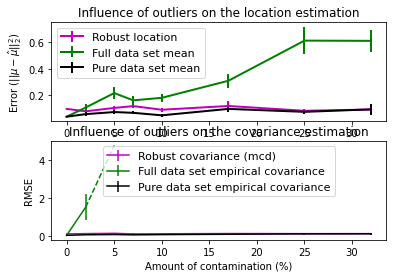

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.covariance import EmpiricalCovariance, MinCovDet

# example settings
n_samples = 80
n_features = 5
repeat = 10

range_n_outliers = np.concatenate(
    (np.linspace(0, n_samples / 8, 5),
     np.linspace(n_samples / 8, n_samples / 2, 5)[1:-1])).astype(int)

# definition of arrays to store results
err_loc_mcd = np.zeros((range_n_outliers.size, repeat))
err_cov_mcd = np.zeros((range_n_outliers.size, repeat))
err_loc_emp_full = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_full = np.zeros((range_n_outliers.size, repeat))
err_loc_emp_pure = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_pure = np.zeros((range_n_outliers.size, repeat))

# computation
for i, n_outliers in enumerate(range_n_outliers):
    for j in range(repeat):

        rng = np.random.RandomState(i * j)

        # generate data
        X = rng.randn(n_samples, n_features)
        # add some outliers
        outliers_index = rng.permutation(n_samples)[:n_outliers]
        outliers_offset = 10. * \
            (np.random.randint(2, size=(n_outliers, n_features)) - 0.5)
        X[outliers_index] += outliers_offset
        inliers_mask = np.ones(n_samples).astype(bool)
        inliers_mask[outliers_index] = False

        # fit a Minimum Covariance Determinant (MCD) robust estimator to data
        mcd = MinCovDet().fit(X)
        # compare raw robust estimates with the true location and covariance
        err_loc_mcd[i, j] = np.sum(mcd.location_ ** 2)
        err_cov_mcd[i, j] = mcd.error_norm(np.eye(n_features))

        # compare estimators learned from the full data set with true
        # parameters
        err_loc_emp_full[i, j] = np.sum(X.mean(0) ** 2)
        err_cov_emp_full[i, j] = EmpiricalCovariance().fit(X).error_norm(
            np.eye(n_features))

        # compare with an empirical covariance learned from a pure data set
        # (i.e. "perfect" mcd)
        pure_X = X[inliers_mask]
        pure_location = pure_X.mean(0)
        pure_emp_cov = EmpiricalCovariance().fit(pure_X)
        err_loc_emp_pure[i, j] = np.sum(pure_location ** 2)
        err_cov_emp_pure[i, j] = pure_emp_cov.error_norm(np.eye(n_features))

# Display results
font_prop = matplotlib.font_manager.FontProperties(size=11)
plt.subplot(2, 1, 1)
lw = 2
plt.errorbar(range_n_outliers, err_loc_mcd.mean(1),
             yerr=err_loc_mcd.std(1) / np.sqrt(repeat),
             label="Robust location", lw=lw, color='m')
plt.errorbar(range_n_outliers, err_loc_emp_full.mean(1),
             yerr=err_loc_emp_full.std(1) / np.sqrt(repeat),
             label="Full data set mean", lw=lw, color='green')
plt.errorbar(range_n_outliers, err_loc_emp_pure.mean(1),
             yerr=err_loc_emp_pure.std(1) / np.sqrt(repeat),
             label="Pure data set mean", lw=lw, color='black')
plt.title("Influence of outliers on the location estimation")
plt.ylabel(r"Error ($||\mu - \hat{\mu}||_2^2$)")
plt.legend(loc="upper left", prop=font_prop)

plt.subplot(2, 1, 2)
x_size = range_n_outliers.size
plt.errorbar(range_n_outliers, err_cov_mcd.mean(1),
             yerr=err_cov_mcd.std(1),
             label="Robust covariance (mcd)", color='m')
plt.errorbar(range_n_outliers[:(x_size // 5 + 1)],
             err_cov_emp_full.mean(1)[:(x_size // 5 + 1)],
             yerr=err_cov_emp_full.std(1)[:(x_size // 5 + 1)],
             label="Full data set empirical covariance", color='green')
plt.plot(range_n_outliers[(x_size // 5):(x_size // 2 - 1)],
         err_cov_emp_full.mean(1)[(x_size // 5):(x_size // 2 - 1)],
         color='green', ls='--')
plt.errorbar(range_n_outliers, err_cov_emp_pure.mean(1),
             yerr=err_cov_emp_pure.std(1),
             label="Pure data set empirical covariance", color='black')
plt.title("Influence of outliers on the covariance estimation")
plt.xlabel("Amount of contamination (%)")
plt.ylabel("RMSE")
plt.legend(loc="upper center", prop=font_prop)

plt.show()

In [32]:
import numpy as np

# for consistent results
np.random.seed(7)

n_samples = 125
n_outliers = 25
n_features = 2

# generate Gaussian data of shape (125, 2)
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

In [33]:
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print('Estimated covariance matrix:\n'
      'MCD (Robust):\n{}\n'
      'MLE:\n{}'.format(robust_cov.covariance_, emp_cov.covariance_))

Estimated covariance matrix:
MCD (Robust):
[[ 3.26253567e+00 -3.06695631e-03]
 [-3.06695631e-03  1.22747343e+00]]
MLE:
[[ 3.23773583 -0.24640578]
 [-0.24640578  7.51963999]]


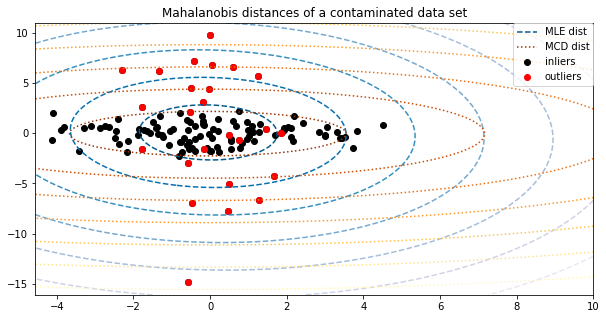

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1],
                         color='black', label='inliers')
outlier_plot = ax.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                          color='red', label='outliers')
ax.set_xlim(ax.get_xlim()[0], 10.)
ax.set_title("Mahalanobis distances of a contaminated data set")

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(xx, yy, np.sqrt(mahal_emp_cov),
                              cmap=plt.cm.PuBu_r, linestyles='dashed')
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(xx, yy, np.sqrt(mahal_robust_cov),
                            cmap=plt.cm.YlOrBr_r, linestyles='dotted')

# Add legend
ax.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
          inlier_plot, outlier_plot],
          ['MLE dist', 'MCD dist', 'inliers', 'outliers'],
          loc="upper right", borderaxespad=0)

plt.show()

c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
c:\users\jatin\appdata\local\programs\python\python38-32\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


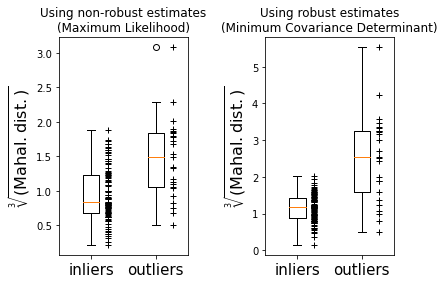

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=.6)

# Calculate cubic root of MLE Mahalanobis distances for samples
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
# Plot boxplots
ax1.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
# Plot individual samples
ax1.plot(np.full(n_samples - n_outliers, 1.26), emp_mahal[:-n_outliers],
         '+k', markeredgewidth=1)
ax1.plot(np.full(n_outliers, 2.26), emp_mahal[-n_outliers:],
         '+k', markeredgewidth=1)
ax1.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax1.set_title("Using non-robust estimates\n(Maximum Likelihood)")

# Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
# Plot boxplots
ax2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
            widths=.25)
# Plot individual samples
ax2.plot(np.full(n_samples - n_outliers, 1.26), robust_mahal[:-n_outliers],
         '+k', markeredgewidth=1)
ax2.plot(np.full(n_outliers, 2.26), robust_mahal[-n_outliers:],
         '+k', markeredgewidth=1)
ax2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax2.set_title("Using robust estimates\n(Minimum Covariance Determinant)")

plt.show()

# Novelty and Outlier Detection

In [4]:
from sklearn.svm import OneClassSVM
X = [[0], [0.44], [0.45], [0.46], [1]]
clf = OneClassSVM(gamma='auto').fit(X)
print(clf.predict(X))
clf.score_samples(X)

[-1  1  1  1 -1]


array([1.77987316, 2.05479873, 2.05560497, 2.05615569, 1.73328509])

In [5]:
from sklearn.ensemble import IsolationForest
X = [[-1.1], [0.3], [0.5], [100]]
clf = IsolationForest(random_state=0).fit(X)
clf.predict([[0.1], [0], [90]])

array([ 1,  1, -1])

In [6]:
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
X = [[-1.1], [0.2], [101.1], [0.3]]
clf = LocalOutlierFactor(n_neighbors=2)
print(clf.fit_predict(X))
clf.negative_outlier_factor_

[ 1  1 -1  1]


array([ -0.98214286,  -1.03703704, -73.36970899,  -0.98214286])

In [7]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
true_cov = np.array([[.8, .3],[.3, .4]])
X = np.random.RandomState(0).multivariate_normal(mean=[0, 0], cov=true_cov, size=500)
cov = EllipticEnvelope(random_state=0).fit(X)
print(cov.predict([[0, 0], [3, 3]]))
print(cov.covariance_)
cov.location_

[ 1 -1]
[[0.74118335 0.25357049]
 [0.25357049 0.30531502]]


array([0.0813539 , 0.04279722])

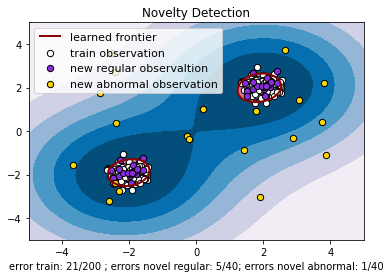

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, X.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s = s, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolor='k')
plt.axis('tight')
plt.ylim((-5, 5))
plt.xlim((-5, 5))
plt.legend([a.collections[0], b1, b2, c], ["learned frontier", "train observation", "new regular observaltion",
                                          "new abnormal observation"], loc="upper left", 
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel("error train: %d/200 ; errors novel regular: %d/40; errors novel abnormal: %d/40"%(n_error_train, n_error_test, 
                                                                                             n_error_outliers))
plt.show()

Automatically created module for IPython interactive environment
________________________________________________________________________________
Modeling distribution of species 'bradypus variegatus'
 - fit OneClassSVM ... done.
 - plot coastlines using basemap
 - predict species distribution

 Area under the ROC curve : 0.868443
________________________________________________________________________________
Modeling distribution of species 'microryzomys minutus'
 - fit OneClassSVM ... done.
 - plot coastlines using basemap
 - predict species distribution

 Area under the ROC curve : 0.993919

time elapsed: 152.24s


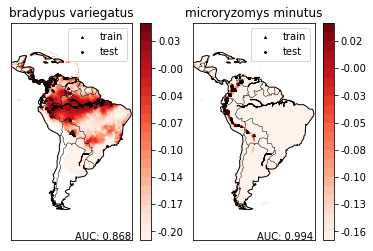

In [15]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn import svm, metrics

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

print(__doc__)


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


def create_species_bunch(species_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information about a particular organism

    This will use the test/train record arrays to extract the
    data specific to the given species name.
    """
    bunch = Bunch(name=' '.join(species_name.split("_")[:2]))
    species_name = species_name.encode('ascii')
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts['species'] == species_name]
        bunch['pts_%s' % label] = pts

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts['dd long'])
        iy = np.searchsorted(ygrid, pts['dd lat'])
        bunch['cov_%s' % label] = coverages[:, -iy, ix].T

    return bunch


def plot_species_distribution(species=("bradypus_variegatus_0",
                                       "microryzomys_minutus_0")):
    """
    Plot the species distribution.
    """
    if len(species) > 2:
        print("Note: when more than two species are provided,"
              " only the first two will be used")

    t0 = time()

    # Load the compressed data
    data = fetch_species_distributions()

    # Set up the data grid
    xgrid, ygrid = construct_grids(data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])

    # create a bunch for each species
    BV_bunch = create_species_bunch(species[0],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)
    MM_bunch = create_species_bunch(species[1],
                                    data.train, data.test,
                                    data.coverages, xgrid, ygrid)

    # background points (grid coordinates) for evaluation
    np.random.seed(13)
    background_points = np.c_[np.random.randint(low=0, high=data.Ny,
                                                size=10000),
                              np.random.randint(low=0, high=data.Nx,
                                                size=10000)].T

    # We'll make use of the fact that coverages[6] has measurements at all
    # land points.  This will help us decide between land and water.
    land_reference = data.coverages[6]

    # Fit, predict, and plot for each species.
    for i, species in enumerate([BV_bunch, MM_bunch]):
        print("_" * 80)
        print("Modeling distribution of species '%s'" % species.name)

        # Standardize features
        mean = species.cov_train.mean(axis=0)
        std = species.cov_train.std(axis=0)
        train_cover_std = (species.cov_train - mean) / std

        # Fit OneClassSVM
        print(" - fit OneClassSVM ... ", end='')
        clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
        clf.fit(train_cover_std)
        print("done.")

        # Plot map of South America
        plt.subplot(1, 2, i + 1)
        if basemap:
            print(" - plot coastlines using basemap")
            m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                        urcrnrlat=Y.max(), llcrnrlon=X.min(),
                        urcrnrlon=X.max(), resolution='c')
            m.drawcoastlines()
            m.drawcountries()
        else:
            print(" - plot coastlines from coverage")
            plt.contour(X, Y, land_reference,
                        levels=[-9998], colors="k",
                        linestyles="solid")
            plt.xticks([])
            plt.yticks([])

        print(" - predict species distribution")

        # Predict species distribution using the training data
        Z = np.ones((data.Ny, data.Nx), dtype=np.float64)

        # We'll predict only for the land points.
        idx = np.where(land_reference > -9999)
        coverages_land = data.coverages[:, idx[0], idx[1]].T

        pred = clf.decision_function((coverages_land - mean) / std)
        Z *= pred.min()
        Z[idx[0], idx[1]] = pred

        levels = np.linspace(Z.min(), Z.max(), 25)
        Z[land_reference == -9999] = -9999

        # plot contours of the prediction
        plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
        plt.colorbar(format='%.2f')

        # scatter training/testing points
        plt.scatter(species.pts_train['dd long'], species.pts_train['dd lat'],
                    s=2 ** 2, c='black',
                    marker='^', label='train')
        plt.scatter(species.pts_test['dd long'], species.pts_test['dd lat'],
                    s=2 ** 2, c='black',
                    marker='x', label='test')
        plt.legend()
        plt.title(species.name)
        plt.axis('equal')

        # Compute AUC with regards to background points
        pred_background = Z[background_points[0], background_points[1]]
        pred_test = clf.decision_function((species.cov_test - mean) / std)
        scores = np.r_[pred_test, pred_background]
        y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
        fpr, tpr, thresholds = metrics.roc_curve(y, scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.text(-35, -70, "AUC: %.3f" % roc_auc, ha="right")
        print("\n Area under the ROC curve : %f" % roc_auc)

    print("\ntime elapsed: %.2fs" % (time() - t0))


plot_species_distribution()
plt.show()

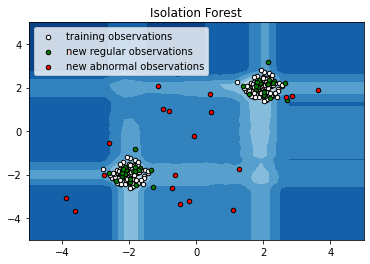

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
X_outliers = rng.uniform(low=-4, high=4, size=(20, 2))
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Isolation Forest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s = 20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="green", s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c], ["training observations", "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

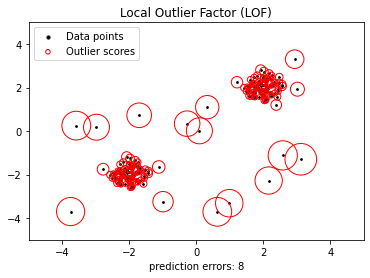

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
np.random.seed(42)
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3, label='Data points')
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolor='r', facecolors='none', label="Outlier scores")
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d"%(n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

# Kernel Density Estimation

In [3]:
from sklearn.neighbors import KernelDensity
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X)
kde.score_samples(X)

array([-0.41075698, -0.41075698, -0.41076071, -0.41075698, -0.41075698,
       -0.41076071])

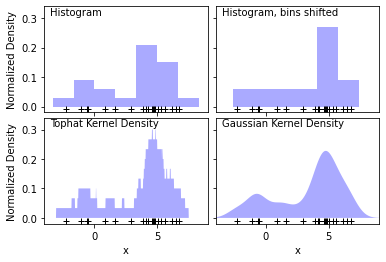

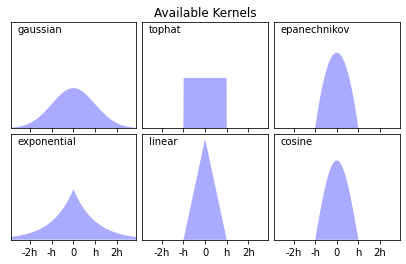

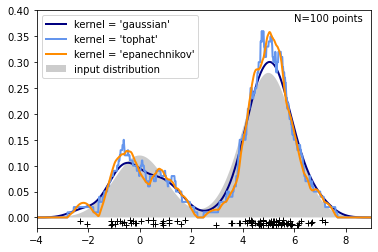

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

# `normed` is being deprecated in favor of `density` in histograms
if parse_version(matplotlib.__version__) >= parse_version('2.1'):
    density_param = {'density': True}
else:
    density_param = {'normed': True}

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')

# ----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'h'
    elif x == -1:
        return '-h'
    else:
        return '%ih' % x


for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')

# ----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')
colors = ['navy', 'cornflowerblue', 'darkorange']
kernels = ['gaussian', 'tophat', 'epanechnikov']
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), color=color, lw=lw,
            linestyle='-', label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

best bandwidth: 3.79269019073225


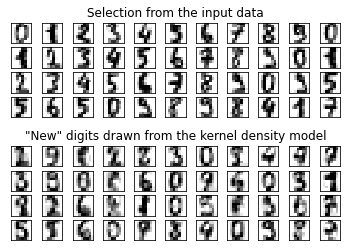

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# load the data
digits = load_digits()

# project the 64-dimensional data to a lower dimension
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)

# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

 - computing KDE in spherical coordinates
 - plot coastlines using basemap
 - computing KDE in spherical coordinates
 - plot coastlines using basemap


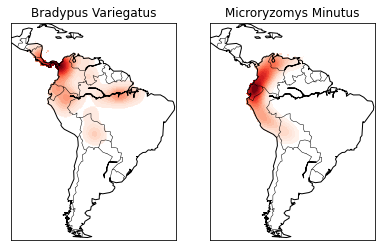

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype='int')
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c')
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(X, Y, land_reference,
                    levels=[-9998], colors="k",
                    linestyles="solid")
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()

# Neural network models (Restricted Boltzmann machines)

In [7]:
import numpy as np
from sklearn.neural_network import BernoulliRBM
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
model = BernoulliRBM(n_components=2)
model.fit(X)

BernoulliRBM(n_components=2)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.51s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.67s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.74, time = 0.64s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.83, time = 0.67s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.62, time = 0.66s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.11, time = 0.67s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.93, time = 0.71s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.67, time = 0.66s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.41, time = 0.63s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.33, time = 0.64s
Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.91      0.93      0.92       184
           2       0.92      0.96      0.94       166
           3       0.94      0.88      0.91       19

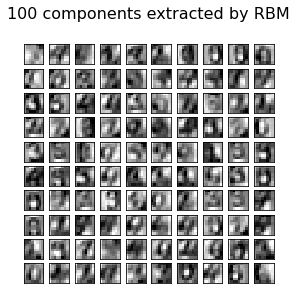

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale
from sklearn.base import clone


# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, 'float32')
X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()